In [2]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

import json
import numpy as np
import datetime as dt
import glob
import os
import pandas as pd

# For loading tweets to generators
from itertools import chain

# For counting number of instances
from collections import Counter

# To show loop progress
from tqdm import *

% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

### Read tweets into pandas dataframe
The name of the game here will be to load tweets with minimum memory usage. My plan is to store the tweets (saved in .json format) in a generator. Then iterate through the object and only store desired information from the tweet. I want to store the following:

- text
- date created
- retweet or original
- user
- number of likes
- number of retweets
- number of user followers
- number of user following

#### Analysis outlook

It might be interesting to try and predict things like number of likes based on the last three features. By converting the number of likes into catagories e.g. none (0), low (1-5), moderate(6-15), high(16-100), famous(100+) we are open to a range of machine learning algorithms such as kNN, binary search tree, OvR (one vs. rest) linear models e.g. linear regression and logistic regression. Should choose categories such that each is well represented.

It occurs to me that I should be collecting tweets after at least a couple days so they can collect likes and retweets. I did this for the most part but not as a rule.

#### Read tweets the lazy way with large memory cost

In [3]:
# # Use glob to search through all dates with specific hashtag
# # then read the files and load the cumulitive result into a
# # list to return

# def merge_tweets(file_root, skip=100):
#     ''' Function that compiles tweets from multiple files
#         into a single list.  This may take a while.
        
#         file_root - Root directory to folder
#         skip (int) - Number of files to skip over before storing
#                      a tweet to memory.
#         '''
#     print(list(glob.iglob(file_root+'*')))
#     tweet_files = list(glob.iglob(file_root+'*'))
#     tweets = []
#     for file in tweet_files:
#         with open(file, 'r') as f:
#             for i, line in enumerate(f.readlines()):
#                     if i%skip == 0:
#                         tweets.append(json.loads(line))
#         print('finished importing file:', file)
#     return tweets
#
# data = merge_tweets(file_root='#nhl/', skip=100)

In [4]:
# Use glob to search through all dates with specific hashtag
# then read the files and load the cumulitive result into generator

def merge_tweets(file_root, skip, file_start=''):
    ''' Function that compiles tweets from multiple files
        into a single list.  This may take a while.
        
        file_root (str) - Root directory to folder
        skip (int)      - To save memory, skip over
                          files using the rule:
                          if i%skip == 0. e.g. skip=1
                          reads in all tweets because
                          i%1 == 0 for all integers i. '''
    
    if not file_start:
        file_start = file_root
    file_root = file_root + '/' + file_start + '*'
    tweet_files = list(glob.iglob(file_root))
    tweets = iter(())
    for f in tqdm(tweet_files):
        t = load_tweets(f, skip)
        tweets = chain(tweets, t)
    return tweets

def load_tweets(file, skip):
    with open(file, 'r') as f:
        tweets = (json.loads(line) for i, line in enumerate(f.readlines()) if i%skip==0)
    return tweets

In [351]:
tweets = load_tweets('#nhl/#nhl_2016-04-12.json', 10)
print(tweets, '\n')
for t in tweets:
    print(t['text'], '\n')
    break

<generator object load_tweets.<locals>.<genexpr> at 0x00000231B8CBB308> 

RT @wyshynski: Stanley Cup Sexiness Ranking: Which first-round series are worth your time? https://t.co/FmIn9KSVLn via @YahooSports #NHL 



In [5]:
if False:
    # Put tweets into a dictionary
    all_tweets = {}

    # Input folder names
    search_phrases = ['#nhl',
                       'Pavelski', 'Lucic',
                       'Ovechkin', 'Giroux',
                       'Jagr', 'Tavares',
                       'Kucherov', 'Mrazek',
                       'Seguin', 'Pominville',
                       'Crosby', 'Lundqvist',
                       'Tarasenko', 'Kane',
                       'Perry', 'Forsberg']

    for folder in tqdm(search_phrases):
        all_tweets[folder] = merge_tweets(file_root=folder, skip=1)

    all_tweets

100%|██████████████████████████████████████████████████████████████████████████████| 17/17 [3:42:00<00:00, 2313.39s/it]


In [6]:
# ''' Test cell '''

# file_root = 'Kane'
# skip = 100
# file_start = ''

# if not file_start:
#     file_start = file_root
# file_root = file_root + '/' + file_start + '*'
# tweet_files = list(glob.iglob(file_root))

# for file in tqdm(tweet_files):
#     print(file)
#     with open(file, 'r') as f:
#         try:
#             tweets = (json.loads(line) for i, line in enumerate(f.readlines()) if i%skip==0)
#         except:
#             print(file, tweets)
#             break
# #         for i, line inenumerate(f.readlines()):
# #             if i%skip == 0:
# #                 try:
# #                     t = json.loads(line)
# #                     # print(t['text'])
# #                 except:
# #                     print('last imported line')
# #                     print(t)


In [7]:
# Iterate through tweets, check for NHL related
# phrases in tweet['text'] and save qualifying
# tweets to a new file

criteria = {'#nhl': ['nhl'],
            'Pavelski': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'SJS', 'sjs', 'sharks', 'Sharks',
                         'jose', 'Jose', 'Joe'],
            'Lucic': ['NHL', 'nhl', 'hockey', 'Hockey',
                      'LAK', 'kings', 'Kings',
                      'angeles', 'Angeles', 'Milan'],
            'Ovechkin': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'WSH', 'wsh', 'caps', 'Caps',
                         'capitals', 'Capitals',
                         'washington', 'Washington',
                         'Alex'],
            'Giroux': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'PHI', 'phi', 'flyers', 'Flyers',
                       'Philadelphia', 'Claude'],
            'Jagr': ['NHL', 'nhl', 'hockey', 'Hockey',
                     'FLA', 'panthers', 'Panthers',
                     'florida', 'Florida', 'Jaromir'],
            'Tavares': ['NHL', 'nhl', 'hockey', 'Hockey',
                        'NYI', 'nyi', 'islanders', 'Islanders',
                        'york', 'York', 'John'],
            'Kucherov': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'TBL', 'tbl', 'lightning', 'Lightning',
                         'tampa', 'Tampa', 'Nikita'],
            'Mrazek': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'DET', 'det', 'Wings', 'wings',
                       'Detroit', 'Petr'],
            'Seguin': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'DAL', 'dal', 'stars', 'Stars',
                       'Dallas', 'Tyler'],
            'Pominville': ['NHL', 'nhl', 'hockey', 'Hockey',
                           'MIN', 'min', 'wild', 'Wild',
                           'Minnesota', 'Jason'],
            'Crosby': ['NHL', 'nhl', 'hockey', 'Hockey',
                       'PIT', 'penguins', 'Penguins',
                       'Pittsburgh', 'Sidney'],
            'Lundqvist': ['NHL', 'nhl', 'hockey', 'Hockey',
                          'NYR', 'nyr', 'rangers', 'Rangers',
                          'york', 'York', 'Henrik'],
            'Tarasenko':['NHL', 'nhl', 'hockey', 'Hockey',
                         'STL', 'stl', 'blues', 'Blues',
                         'louis', 'Louis', 'Vladimir'],
            'Kane': ['NHL', 'nhl', 'hockey', 'Hockey',
                     'CHI', 'chi', 'hawks', 'Hawks',
                     'chicago', 'Chicago', 'Patrick'],
            'Perry': ['NHL', 'nhl', 'hockey', 'Hockey',
                      'ducks', 'Ducks', 'Corey'],
            'Forsberg': ['NHL', 'nhl', 'hockey', 'Hockey',
                         'NSH', 'nsh', 'predators', 'Predators',
                         'Nashville', 'Filip']}

if False:
    for folder in tqdm(all_tweets.keys()):
        with open(folder+'/filtered_tweets.json', 'w') as f:
            for t in all_tweets[folder]:
                for word in criteria[folder]:
                    if word in t['text']:
                        json.dump(t, f)
                        f.write('\n')
                        break

100%|█████████████████████████████████████████████████████████████████████████████| 17/17 [34:25:23<00:00, 1080.97s/it]


In [8]:
# Read in filtered tweets

if True:
    
    # Put tweets into a dictionary
    all_tweets = {}
    
    # Input folder names
    search_phrases = ['#nhl',
                       'Pavelski', 'Lucic',
                       'Ovechkin', 'Giroux',
                       'Jagr', 'Tavares',
                       'Kucherov', 'Mrazek',
                       'Seguin', 'Pominville',
                       'Crosby', 'Lundqvist',
                       'Tarasenko', 'Kane',
                       'Perry', 'Forsberg']

    for folder in tqdm(search_phrases):
        all_tweets[folder] = merge_tweets(file_root=folder, skip=1,
                                          file_start='filtered_tweets')

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:42<00:00,  5.63s/it]


In [9]:
# Iterate over generators containing tweets and
# append desired information to lists

data = {'search_phrase': [], 'text': [], 'screen_name': [], 'created_at': [],
        'retweet_count': [], 'favorite_count': [],
        'friends_count': [], 'followers_count': []}

for folder in tqdm(all_tweets.keys()):
    for t in all_tweets[folder]:
        data['search_phrase'].append(folder)
        data['text'].append(t['text'])
        data['screen_name'].append(t['user']['screen_name'])
        data['created_at'].append(t['created_at'])
        data['retweet_count'].append(t['retweet_count'])
        data['favorite_count'].append(t['favorite_count'])
        data['friends_count'].append(t['user']['friends_count'])
        data['followers_count'].append(t['user']['followers_count'])


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:58<00:00,  2.12s/it]


In [10]:
# Create pandas dataframe from dictionary

df = pd.DataFrame(data)

In [11]:
# Drop duplicate entries that may exist

df.drop_duplicates(inplace=True)

In [12]:
# Add column for retweet or original
RT = []
for t in df.text:
    RT.append(t.split()[0]=='RT')
df['RT'] = RT

# Convert created_at to datetimes
df['created_at'] = pd.to_datetime(df['created_at'])

df.head()

created_at  favorite_count  followers_count  friends_count  \
0 2016-04-13 23:59:16               0              743            434   
1 2016-04-13 23:59:03               0             1141            300   
2 2016-04-13 23:59:03               0               16             50   
3 2016-04-13 23:58:41               0              614            637   
4 2016-04-13 23:58:32               0               97            257   

   retweet_count      screen_name search_phrase  \
0              2         allyoddo          Kane   
1            195      peeweepr915          Kane   
2            195      nikkicat100          Kane   
3            195  rebecca_grigoli          Kane   
4            195        jjmm_9999          Kane   

                                                text    RT  
0  RT @_morgiiie: ain't no body like Patrick Kane...  True  
1  RT @NHLBlackhawks: Patrick Kane sat down to ta...  True  
2  RT @NHLBlackhawks: Patrick Kane sat down to ta...  True  
3  RT @NHLBlackhawks: Patrick Kane sat down to ta...  True  
4  RT @NHLBlackhawks: Patrick Kane sat down to ta...  True

In [13]:
df.dtypes

created_at         datetime64[ns]
favorite_count              int64
followers_count             int64
friends_count               int64
retweet_count               int64
screen_name                object
search_phrase              object
text                       object
RT                           bool
dtype: object

In [14]:
df.describe()

favorite_count  followers_count   friends_count  retweet_count  \
count   856354.000000    856354.000000   856354.000000  856354.000000   
mean         1.129773      5558.474850      801.909508     325.596565   
std         27.474659    214399.322581     3605.409805    1035.009801   
min          0.000000         0.000000        0.000000       0.000000   
25%          0.000000       104.000000      150.000000       0.000000   
50%          0.000000       288.000000      346.000000       6.000000   
75%          0.000000       665.000000      757.000000     182.000000   
max       7694.000000  28759647.000000  1376172.000000  156304.000000   

             RT  
count    856354  
mean   0.570883  
std     0.49495  
min       False  
25%           0  
50%           1  
75%           1  
max        True

In [315]:
len(np.unique(df.text))

403601

### Test cells for searching dataframe

In [15]:
df2 = df.copy()

In [350]:
df2[(df.favorite_count == 0)&(df.retweet_count >= 20)&(df.RT == False)]

created_at  favorite_count  followers_count  friends_count  \
457473 2016-05-16 13:59:50               0               69              5   
501015 2016-05-07 06:59:41               0            21285          19252   
796632 2016-05-10 16:47:42               0                7              4   

        retweet_count      screen_name search_phrase  \
457473             27   Pavelski4NHL17      Pavelski   
501015             21            0l1l2        Seguin   
796632             20  tarasenko_nhl17     Tarasenko   

                                                     text     RT  
457473  Pavelski moves on to the final round. Voting e...  False  
501015  Stars’ Tyler Seguin: Doesn’t join team in Minn...  False  
796632  Add #NHL17Tarasenko to all your tweets! #NHL17...  False

### Histograms of tweets during the playoffs

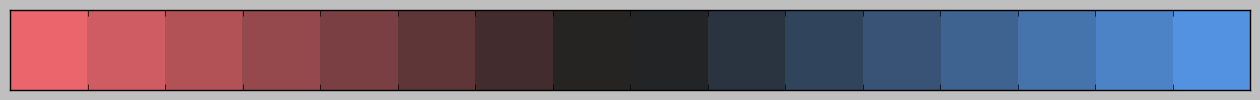

In [23]:
# Get our color palettes
import seaborn.apionly as sns

colors_1 = sns.diverging_palette(10, 250, l=60, n=16, center='dark')
sns.palplot(sns.diverging_palette(10, 250, l=60, n=16, center='dark'))
plt.show()
east_team_map =  ['#0161AB', '#E51837', '#F4793E', '#C51230',
                  '#F57D31', '#002147', '#000000', '#C5B358']
west_team_map =   ['#000000', '#C51230', '#F57D31', '#C60C30',
                   '#016F4A', '#FDBB30', '#00529C', '#007889']
colors_dict = {'Lundqvist': east_team_map[0],
               'Mrazek': east_team_map[1],
               'Giroux': east_team_map[2],
               'Jagr': east_team_map[3],
               'Tavares': east_team_map[4],
               'Ovechkin': east_team_map[5],
               'Kucherov': east_team_map[6],
               'Crosby': east_team_map[7],
               'Lucic': west_team_map[0],
               'Pominville': west_team_map[1],
               'Perry': west_team_map[2],
               'Kane': west_team_map[3],
               'Seguin': west_team_map[4],
               'Forsberg': west_team_map[5],
               'Tarasenko': west_team_map[6],
               'Pavelski': west_team_map[7]}

In [18]:
np.unique(df.search_phrase)

array(['#nhl', 'Crosby', 'Forsberg', 'Giroux', 'Jagr', 'Kane', 'Kucherov',
       'Lucic', 'Lundqvist', 'Mrazek', 'Ovechkin', 'Pavelski', 'Perry',
       'Pominville', 'Seguin', 'Tarasenko', 'Tavares'], dtype=object)

In [19]:
# Convert datetimes to timestamps for histograms

to_timestamp = np.vectorize(lambda x: x.timestamp())

time_stamps = {}
for name in tqdm(np.unique(df.search_phrase)):
    time_stamps[name] = to_timestamp(list(df[(df.search_phrase == name)].created_at))

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.12it/s]


In [20]:
# Create numpy histograms

player_hist_bins = 100

my_hists, my_hist_times = {}, {}
for name in tqdm(np.unique(df.search_phrase)):
    my_hists[name] = np.histogram(time_stamps[name], bins=player_hist_bins)
    my_hist_times[name] = [dt.datetime.fromtimestamp(t) for t in my_hists[name][1][:-1]]

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 544.62it/s]


In [24]:
nhl_hist_bins = 65
my_hists['#nhl'] = np.histogram(time_stamps['#nhl'], bins=nhl_hist_bins)
my_hist_times['#nhl'] = [dt.datetime.fromtimestamp(t) for t in my_hists['#nhl'][1][:-1]]

delta = max(df.created_at)-min(df.created_at)
nhl_bin_width = (delta/nhl_hist_bins).days*24 + \
                (delta/nhl_hist_bins).seconds/60/60
print('NHL bin width: {} hours'.format(nhl_bin_width))

NHL bin width: 23.99888888888889 hours


In [92]:
print('Date        Number of counts')
print('----------------------------------')
for i, (a, b) in enumerate(zip(my_hists['#nhl'][0], my_hist_times['#nhl'])):
    print(i, (b+dt.timedelta(hours=2)).strftime('%b %d'), '  ', a)

Date        Number of counts
----------------------------------
0 Apr 12    1190
1 Apr 13    1491
2 Apr 14    1691
3 Apr 15    1403
4 Apr 16    1673
5 Apr 17    1218
6 Apr 18    1599
7 Apr 19    1456
8 Apr 20    1884
9 Apr 21    1283
10 Apr 22    1459
11 Apr 23    1487
12 Apr 24    1476
13 Apr 25    1135
14 Apr 26    1952
15 Apr 27    865
16 Apr 28    1523
17 Apr 29    1961
18 Apr 30    1169
19 May 01    1948
20 May 02    975
21 May 03    1370
22 May 04    1292
23 May 05    1445
24 May 06    1197
25 May 07    796
26 May 08    989
27 May 09    784
28 May 10    1010
29 May 11    1563
30 May 12    0
31 May 13    1336
32 May 14    1002
33 May 15    654
34 May 16    1129
35 May 17    1087
36 May 18    772
37 May 19    892
38 May 20    723
39 May 21    854
40 May 22    650
41 May 23    946
42 May 24    612
43 May 25    891
44 May 26    1113
45 May 27    1626
46 May 28    467
47 May 29    400
48 May 30    682
49 May 31    1083
50 Jun 01    692
51 Jun 02    972
52 Jun 03    621
53 Jun 04    65

I missed a day of data collection on May 12th :(

In [86]:
my_hist_times['#nhl'][1]+dt.timedelta(hours=12)

datetime.datetime(2016, 4, 13, 12, 3, 12, 738461)

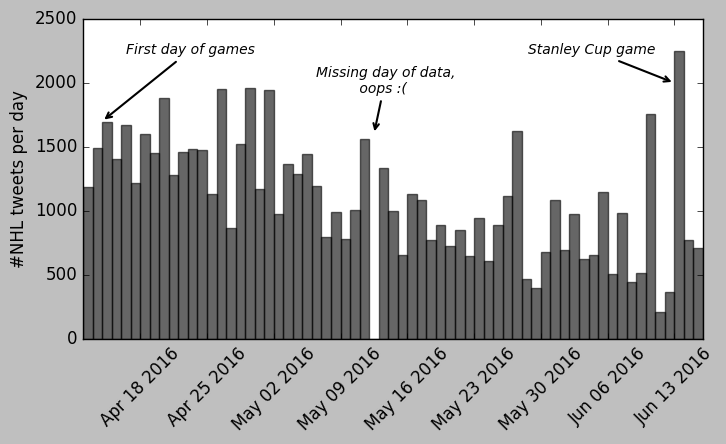

In [316]:
# with plt.xkcd():
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)

ax.bar(my_hist_times['#nhl'], my_hists['#nhl'][0],
       color='black', lw=1, alpha=0.6, width=1)

tks = ax.xaxis.get_majorticklabels()
plt.setp(tks, rotation=45)

ax.set_ylabel('#NHL tweets per day')

ax.annotate('First day of games',
            style='italic',
            fontsize=10,
            xy=(my_hist_times['#nhl'][2], 1700),
            xytext=(my_hist_times['#nhl'][18], 2200), 
            xycoords='data', textcoords='data', ha='right', va='bottom', 
            arrowprops=dict(arrowstyle='->', lw=1.5))

ax.annotate('Missing day of data,\n oops :(           ',
            style='italic',
            fontsize=10,
            xy=(my_hist_times['#nhl'][30]+dt.timedelta(hours=12), 1600),
            xytext=(my_hist_times['#nhl'][39], 1900), 
            xycoords='data', textcoords='data', ha='right', va='bottom', 
            arrowprops=dict(arrowstyle='->', lw=1.5))

ax.annotate('Stanley Cup game',
            style='italic',
            fontsize=10,
            xy=(my_hist_times['#nhl'][62], 2000),
            xytext=(my_hist_times['#nhl'][60], 2200), 
            xycoords='data', textcoords='data', ha='right', va='bottom', 
            arrowprops=dict(arrowstyle='->', lw=1.5))

plt.savefig('figures/#nhl_hist.png', bbox_inches='tight', dpi=144)
plt.show()

In [41]:
all_players = ['Lundqvist', 'Mrazek', 'Giroux', 'Jagr',
               'Tavares', 'Ovechkin', 'Kucherov', 'Crosby',
               'Pavelski', 'Tarasenko', 'Forsberg', 'Seguin',
               'Kane', 'Perry', 'Pominville', 'Lucic']
east_players = all_players[:8]
west_players = all_players[8:][::-1]

In [42]:
east_players

['Lundqvist',
 'Mrazek',
 'Giroux',
 'Jagr',
 'Tavares',
 'Ovechkin',
 'Kucherov',
 'Crosby']

In [43]:
west_players

['Lucic',
 'Pominville',
 'Perry',
 'Kane',
 'Seguin',
 'Forsberg',
 'Tarasenko',
 'Pavelski']

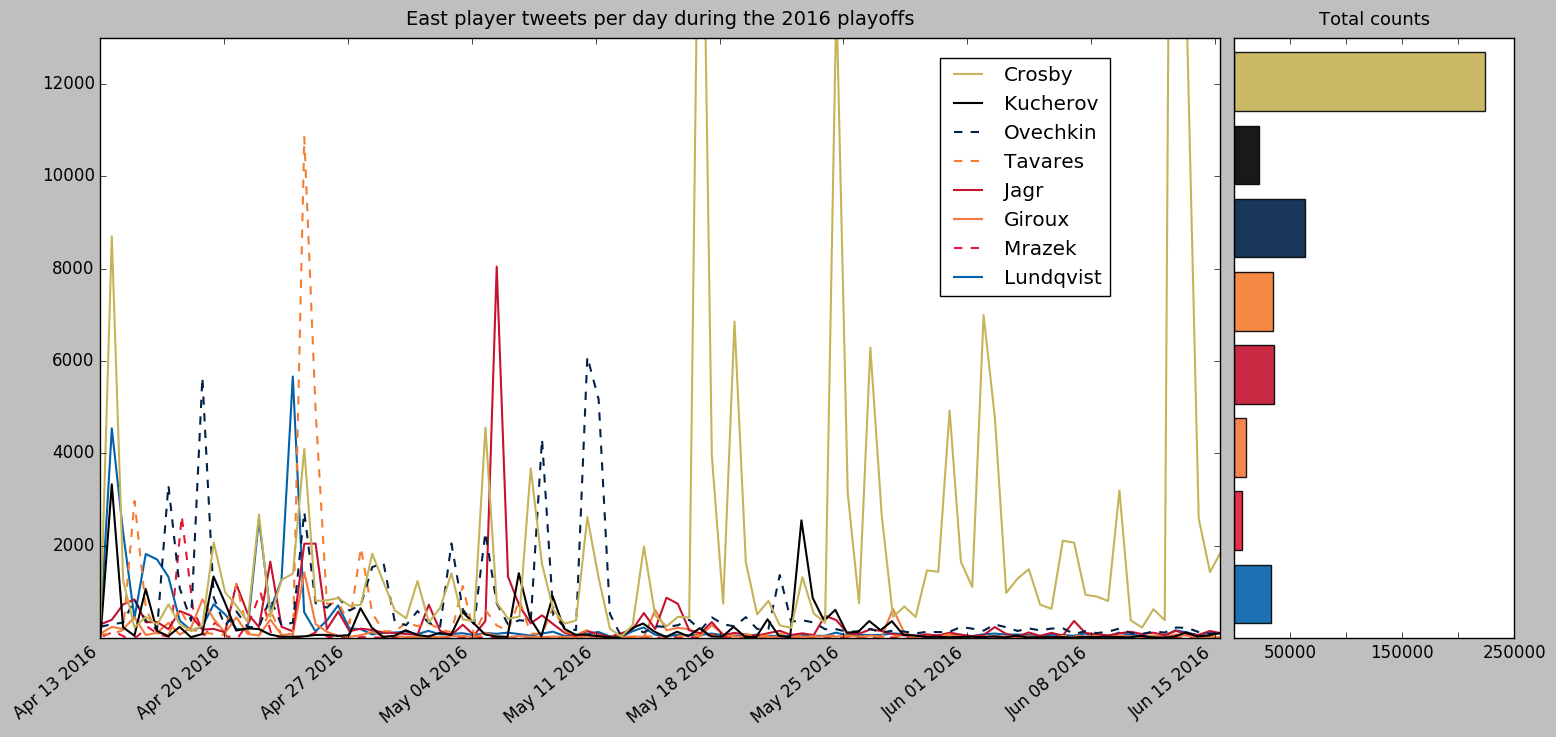

In [386]:
# with plt.xkcd():
if True:
    fig = plt.figure(figsize=(14,6))
    for i, player in enumerate(east_players):
        left, bottom, width, height = [0.0, 0.0, 0.8, 1.0]
        ax = fig.add_axes([left, bottom, width, height])
        if player == 'Mrazek' or player == 'Ovechkin' or player == 'Tavares':
            ax.plot(my_hist_times[player], my_hists[player][0],
                    label=player, linestyle='--',
                    color=colors_dict[player], linewidth=1.5)
        else:
            ax.plot(my_hist_times[player], my_hists[player][0],
                    label=player,
                    color=colors_dict[player], linewidth=1.5)
        ax.set_ylim(0, 13000)
        # A little hack to get April 13th axes label showing up
        xlims = ax.get_xlim()
        ax.set_xlim(xlims[0]-0.001, xlims[1])
        
        tks = ax.xaxis.get_majorticklabels()
        for tick in tks:
            tick.set_horizontalalignment('right')
        plt.setp(tks, rotation=40)
        
    for lab in ax.get_yticklabels():
        lab.set_visible(False)
        break
    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1], loc=(0.75, 0.57))
    ax.set_title('East player tweets per day during the 2016 playoffs', y=1.01, fontsize=14)
    
    left, bottom, width, height = [0.81, 0.0, 0.2, 1.0]
    ax_bar = fig.add_axes([left, bottom, width, height])
    ax_bar.barh(range(8), [sum(my_hists[p][0]) for p in east_players],
                color=[colors_dict[p] for p in east_players], alpha=0.9)
    ax_bar.set_yticks([])
    ax_bar.set_yticklabels([])
    ax_bar.set_ylim(-0.2, 8)
    ax_bar.set_title('Total counts', y=1.01, fontsize=13)
    for label in ax_bar.get_xticklabels()[::2]:
        label.set_visible(False)

    plt.savefig('figures/east_players.png', bbox_inches='tight', dpi=144)
    plt.show()

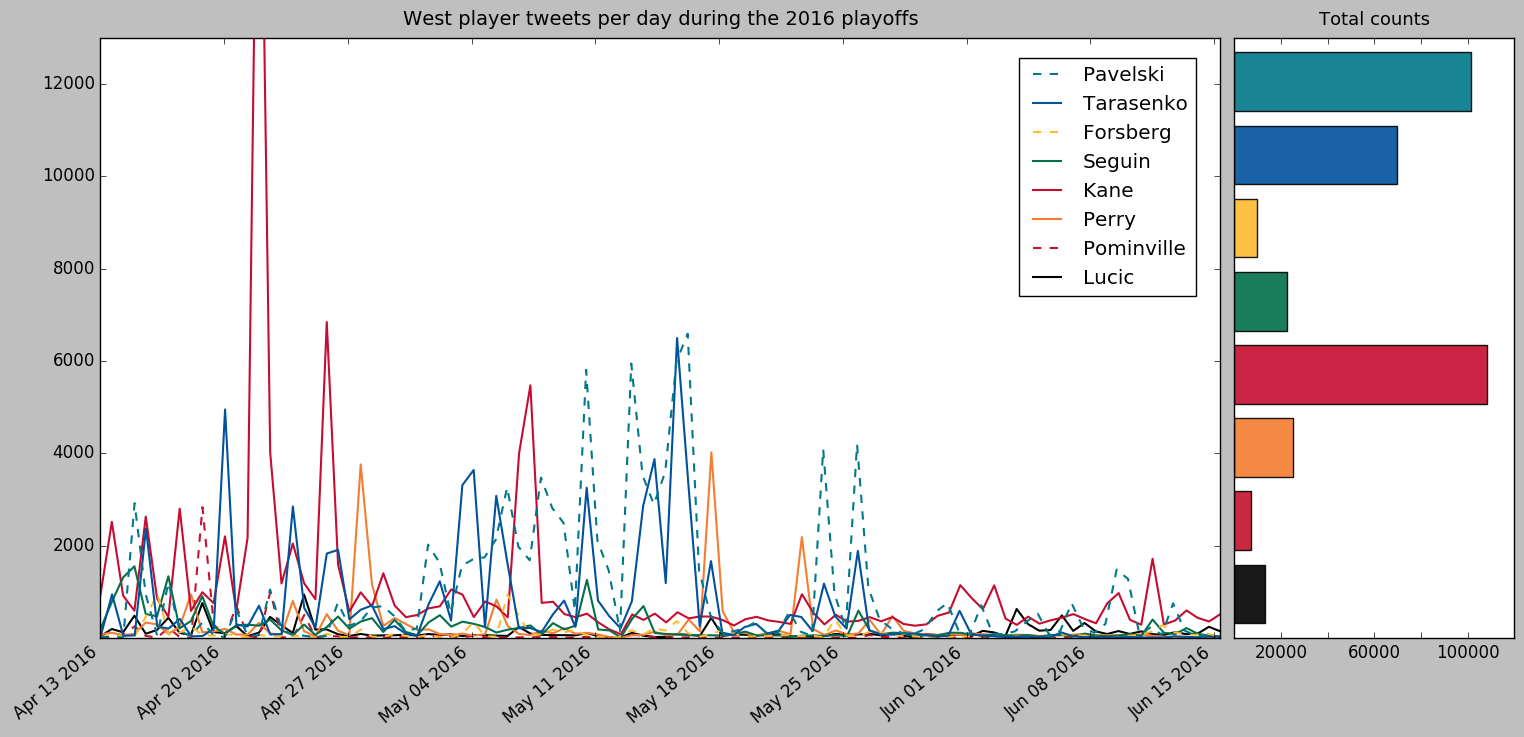

In [387]:
# with plt.xkcd():
if True:
    fig = plt.figure(figsize=(14,6))
    for i, player in enumerate(west_players):
        left, bottom, width, height = [0.0, 0.0, 0.8, 1.0]
        ax = fig.add_axes([left, bottom, width, height])
        if player == 'Pavelski' or player == 'Forsberg' or player == 'Pominville':
            ax.plot(my_hist_times[player], my_hists[player][0],
                    label=player, linestyle='--',
                    color=colors_dict[player], linewidth=1.5)
        else:
            ax.plot(my_hist_times[player], my_hists[player][0],
                    label=player,
                    color=colors_dict[player], linewidth=1.5)
        ax.set_ylim(0, 13000)
        
        tks = ax.xaxis.get_majorticklabels()
        for tick in tks:
            tick.set_horizontalalignment('right')
        plt.setp(tks, rotation=40)
        
    for lab in ax.get_yticklabels():
        lab.set_visible(False)
        break

        
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1], loc=(0.82, 0.57))
    ax.set_title('West player tweets per day during the 2016 playoffs', y=1.01, fontsize=14)
    
    left, bottom, width, height = [0.81, 0.0, 0.2, 1.0]
    ax_bar = fig.add_axes([left, bottom, width, height])
    ax_bar.barh(range(8), [sum(my_hists[p][0]) for p in west_players],
                color=[colors_dict[p] for p in west_players], alpha=0.9)
    ax_bar.set_yticks([])
    ax_bar.set_yticklabels([])
    ax_bar.set_ylim(-0.2, 8)
    ax_bar.set_title('Total counts', y=1.01, fontsize=13)
    for label in ax_bar.get_xticklabels()[::2]:
        label.set_visible(False)
    
    plt.savefig('figures/west_players.png', bbox_inches='tight', dpi=144)
    plt.show()

#### Iterate through players and save a figure for each

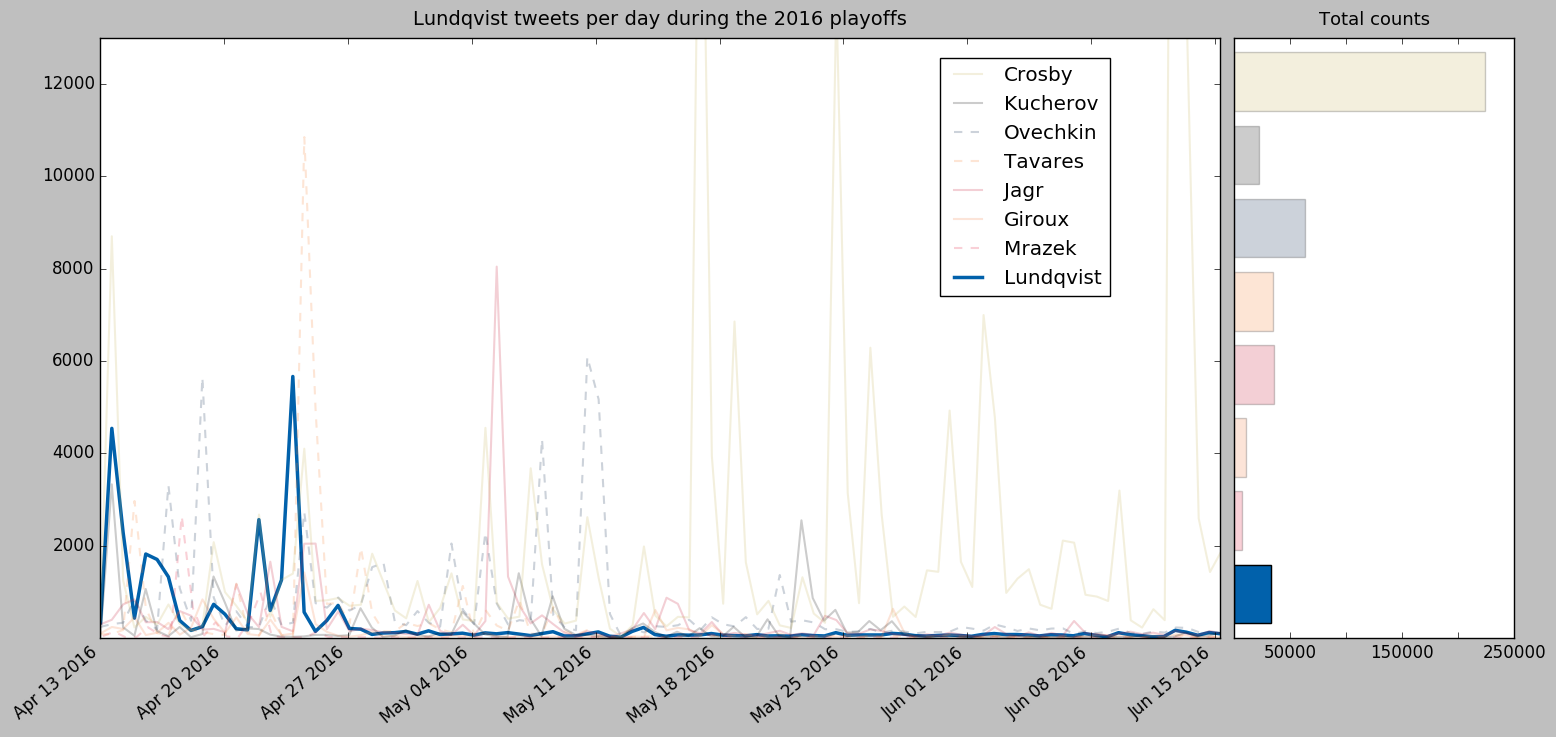

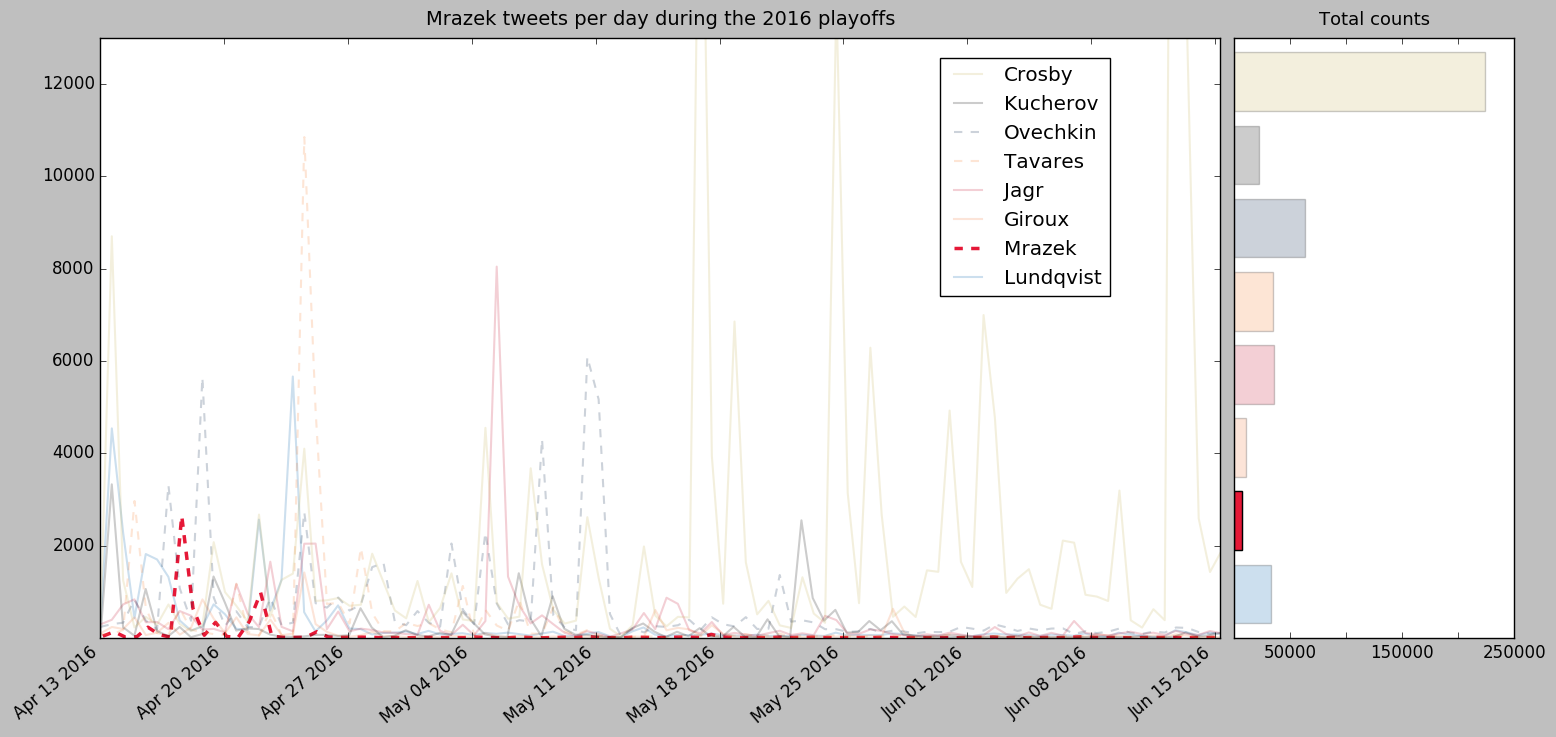

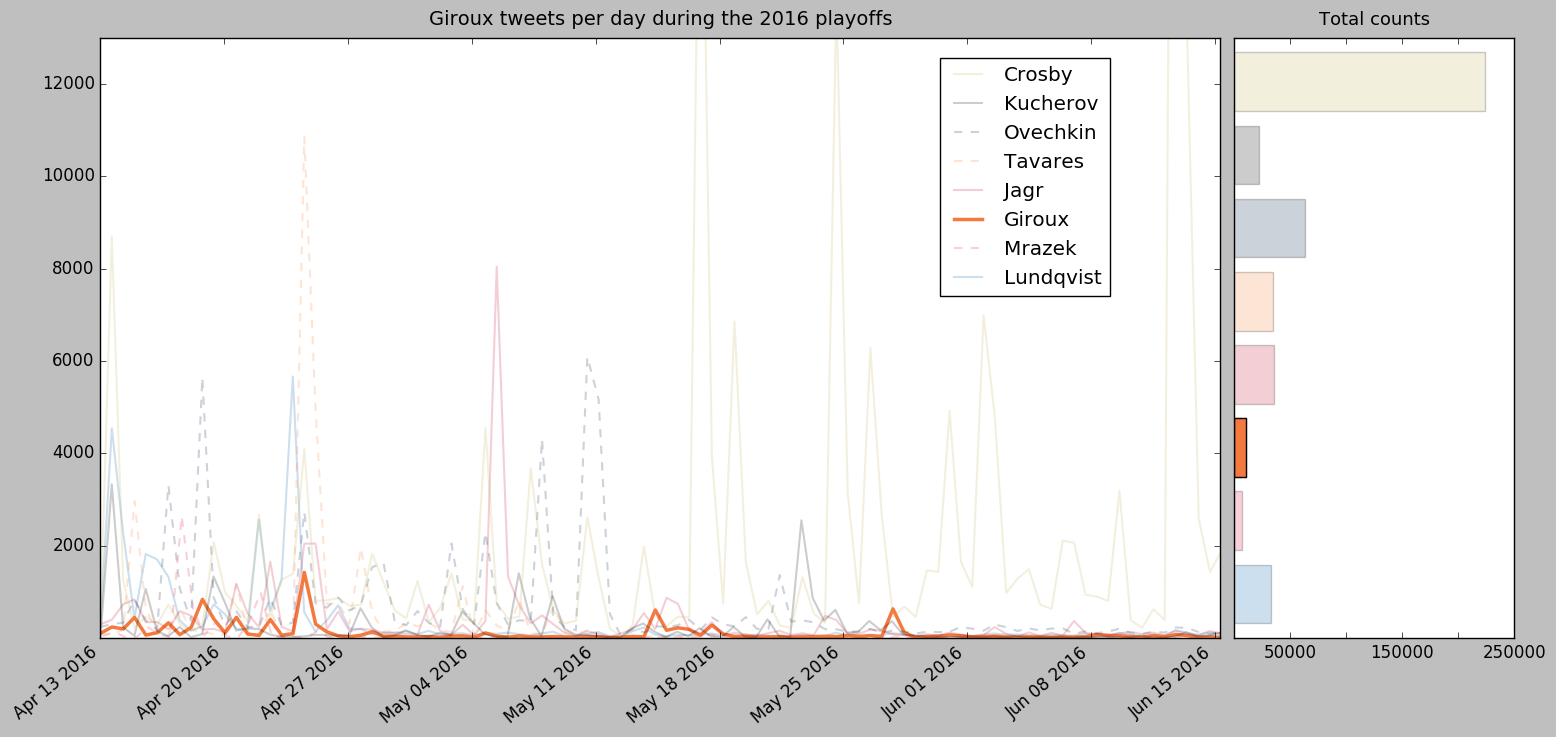

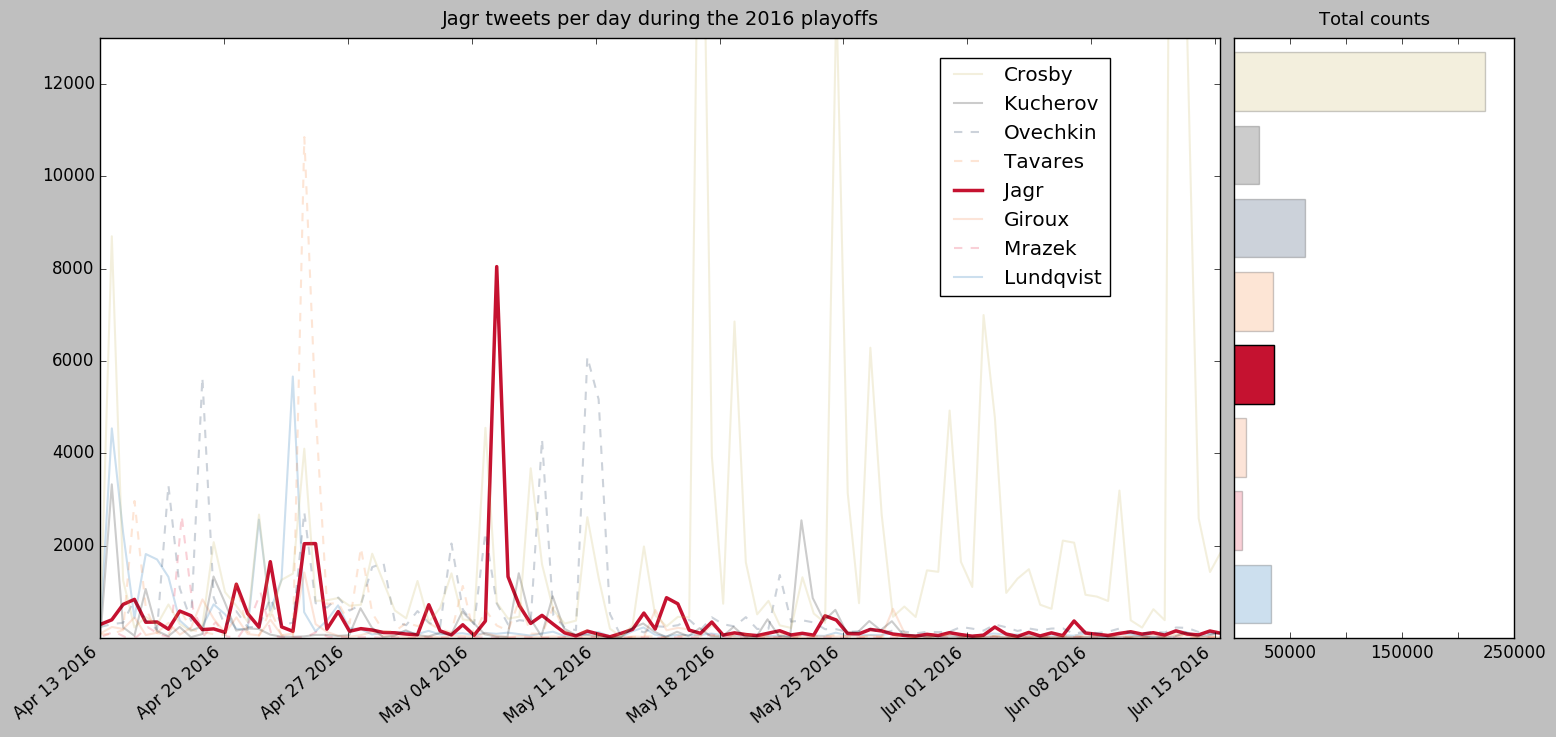

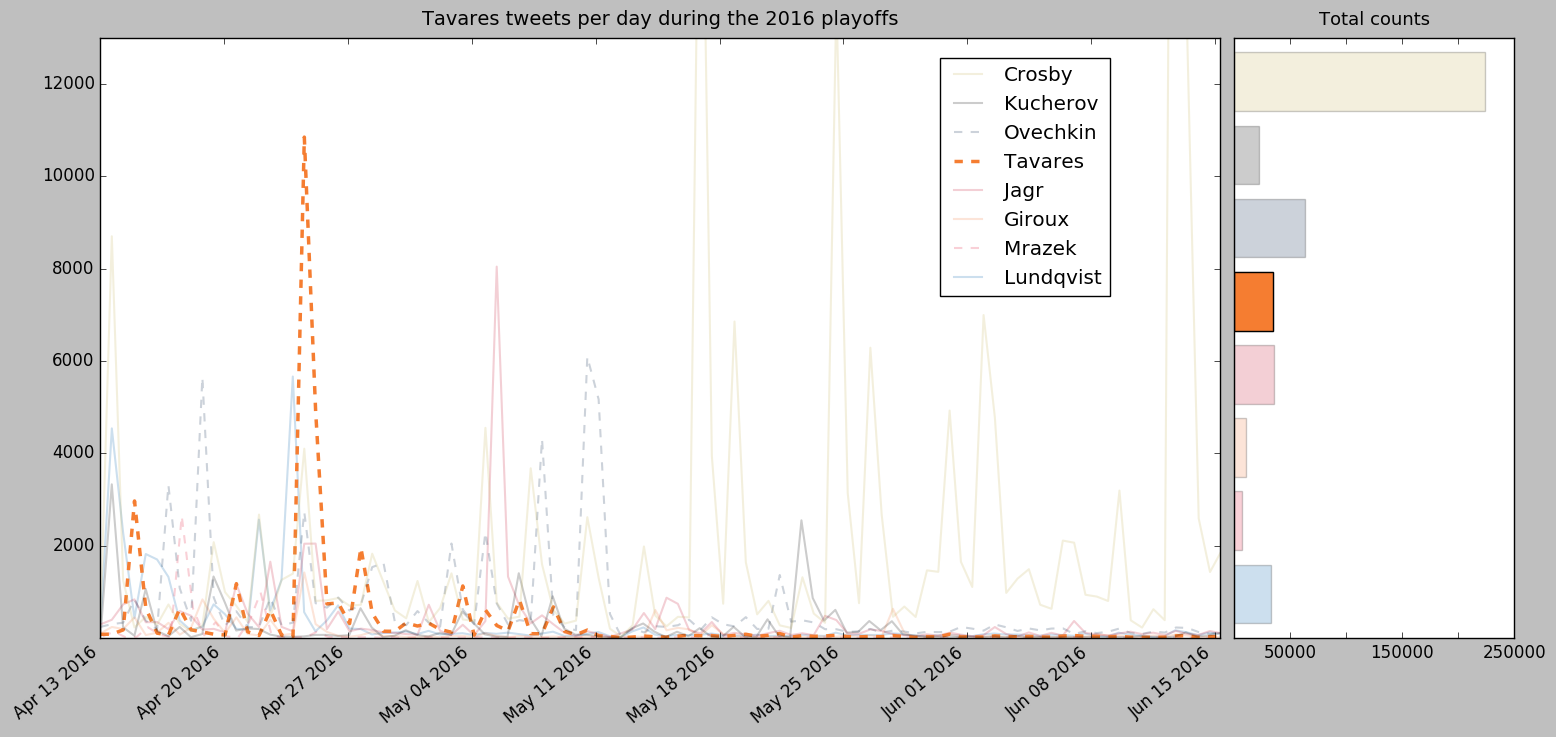

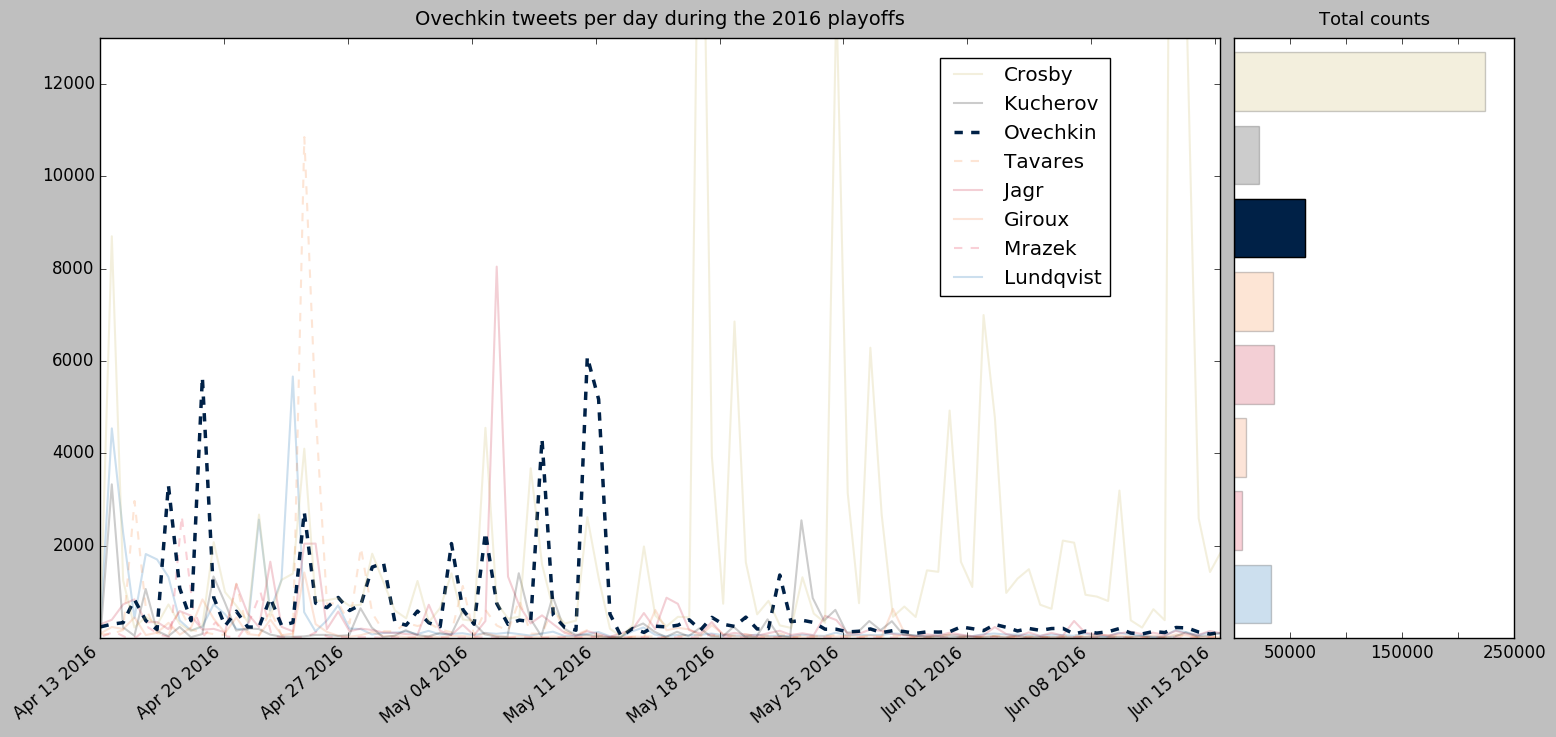

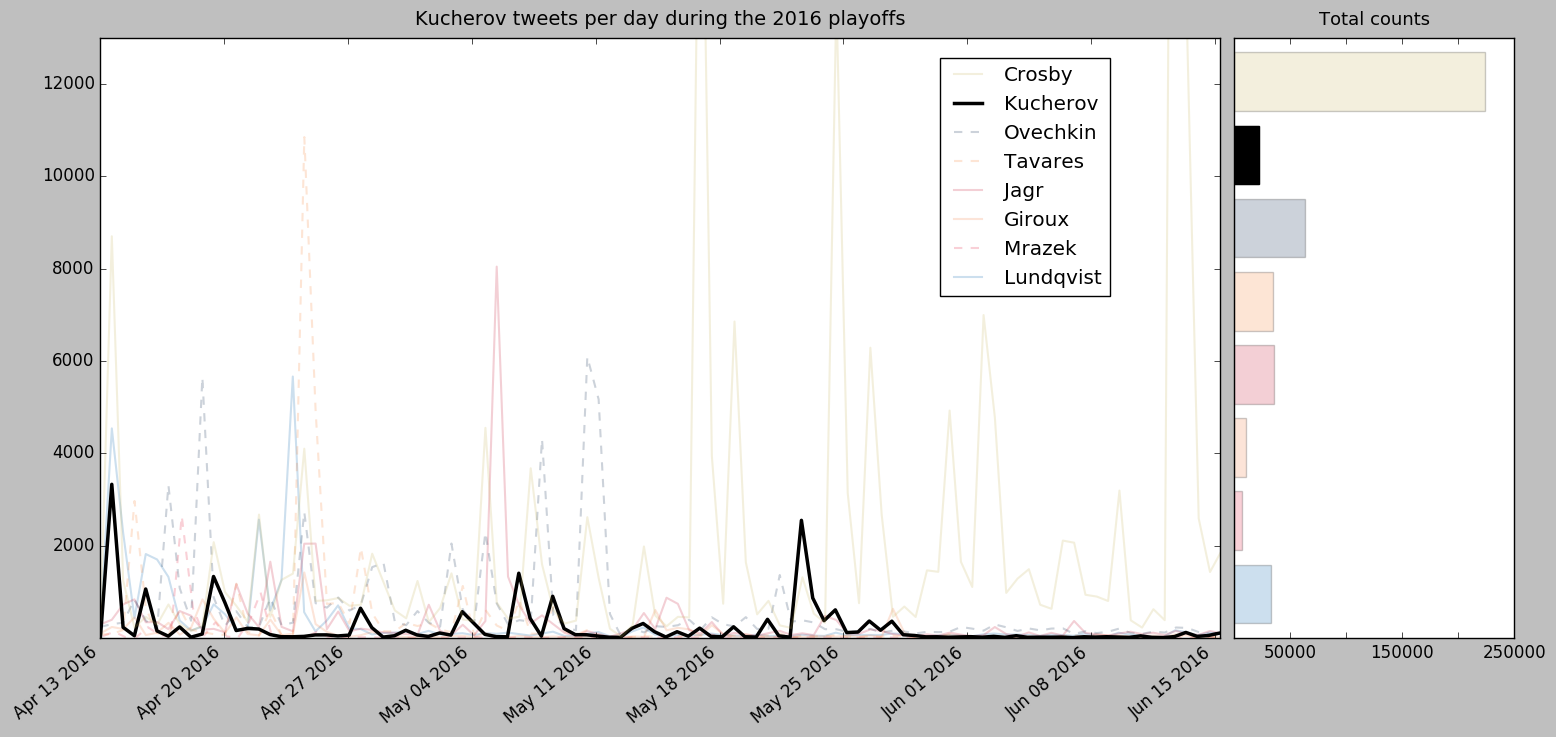

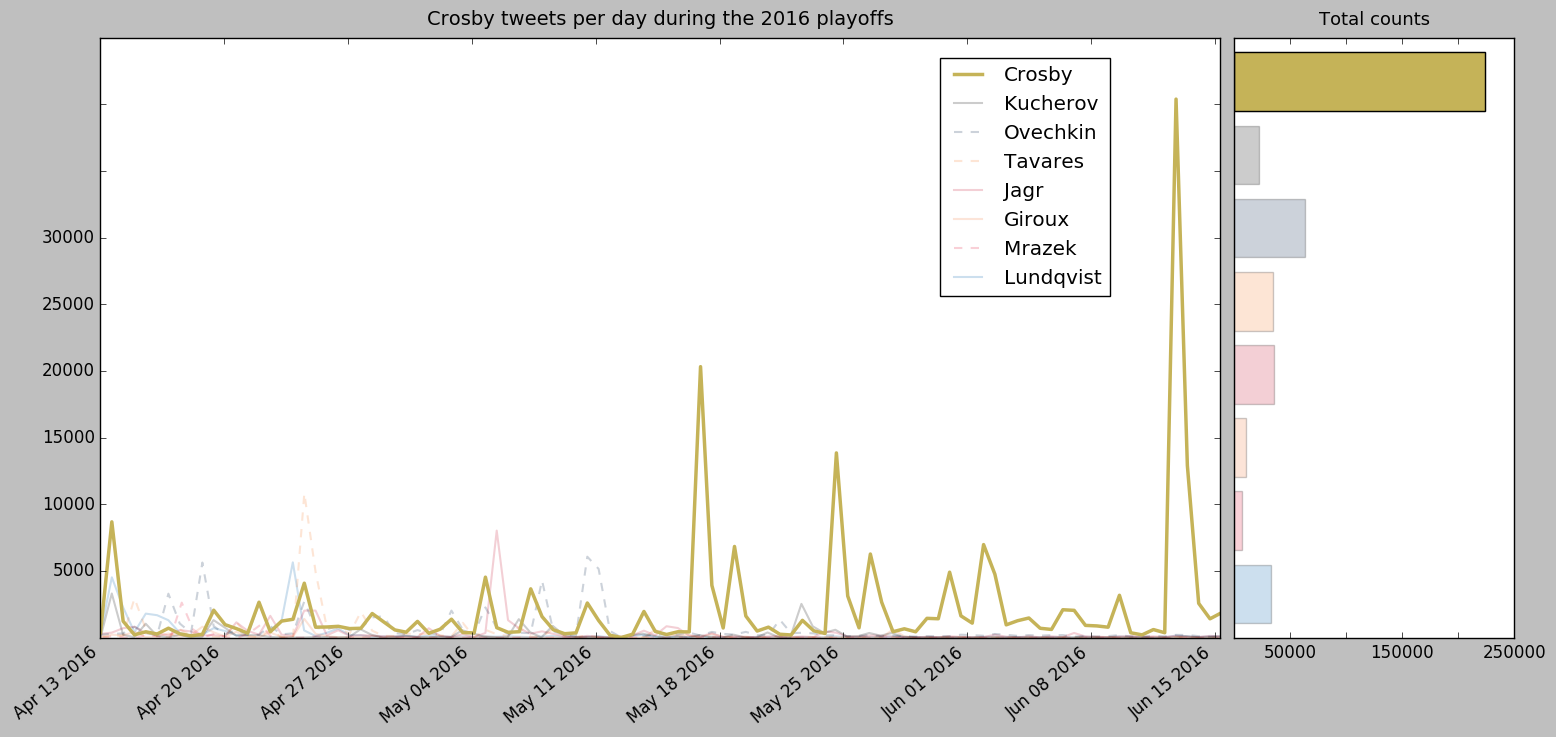

In [385]:
for ip, p in enumerate(east_players):
    fig = plt.figure(figsize=(14,6))
    for i, player in enumerate(east_players):
        left, bottom, width, height = [0.0, 0.0, 0.8, 1.0]
        ax = fig.add_axes([left, bottom, width, height])
        if p != player:
            if player == 'Mrazek' or player == 'Ovechkin' or player == 'Tavares':
                ax.plot(my_hist_times[player], my_hists[player][0],
                        label=player, linestyle='--', alpha=0.2,
                        color=colors_dict[player], linewidth=1.5)
            else:
                ax.plot(my_hist_times[player], my_hists[player][0],
                        label=player, alpha=0.2,
                        color=colors_dict[player], linewidth=1.5)
            if p != 'Crosby':
                ax.set_ylim(0, 13000)
                
            # A little hack to get April 13th axes label showing up
            xlims = ax.get_xlim()
            ax.set_xlim(xlims[0]-0.001, xlims[1])
            
            tks = ax.xaxis.get_majorticklabels()
            for tick in tks:
                tick.set_horizontalalignment('right')
            plt.setp(tks, rotation=40)
        else:
            if player == 'Mrazek' or player == 'Ovechkin' or player == 'Tavares':
                ax.plot(my_hist_times[p], my_hists[p][0],
                        color=colors_dict[p], linewidth=2.5,
                        label=p, linestyle='--')
            else:
                ax.plot(my_hist_times[p], my_hists[p][0],
                        color=colors_dict[p], linewidth=2.5,
                        label=p)
            if p != 'Crosby':
                ax.set_ylim(0, 13000)
                
            # A little hack to get April 13th axes label showing up
            xlims = ax.get_xlim()
            ax.set_xlim(xlims[0]-0.001, xlims[1])
            
            tks = ax.xaxis.get_majorticklabels()
            for tick in tks:
                tick.set_horizontalalignment('right')
            plt.setp(tks, rotation=40)
            
        for lab in ax.get_yticklabels():
            lab.set_visible(False)
            break

    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1], loc=(0.75, 0.57))

    ax.set_title(p+' tweets per day during the 2016 playoffs', y=1.01, fontsize=14)
    
    left, bottom, width, height = [0.81, 0.0, 0.2, 1.0]
    ax_bar = fig.add_axes([left, bottom, width, height])
    ax_bar.barh(range(8), [sum(my_hists[p][0]) for p in east_players],
                color=[colors_dict[p] for p in east_players], alpha=0.2)
    ax_bar.barh(ip, sum(my_hists[p][0]), color=colors_dict[p])
    ax_bar.set_yticks([])
    ax_bar.set_yticklabels([])
    ax_bar.set_ylim(-0.2, 8)
    ax_bar.set_title('Total counts', y=1.01, fontsize=13)
    for label in ax_bar.get_xticklabels()[::2]:
        label.set_visible(False)
        
    plt.savefig('figures/east_players/'+p+'.png', bbox_inches='tight', dpi=144)
        
    plt.show()

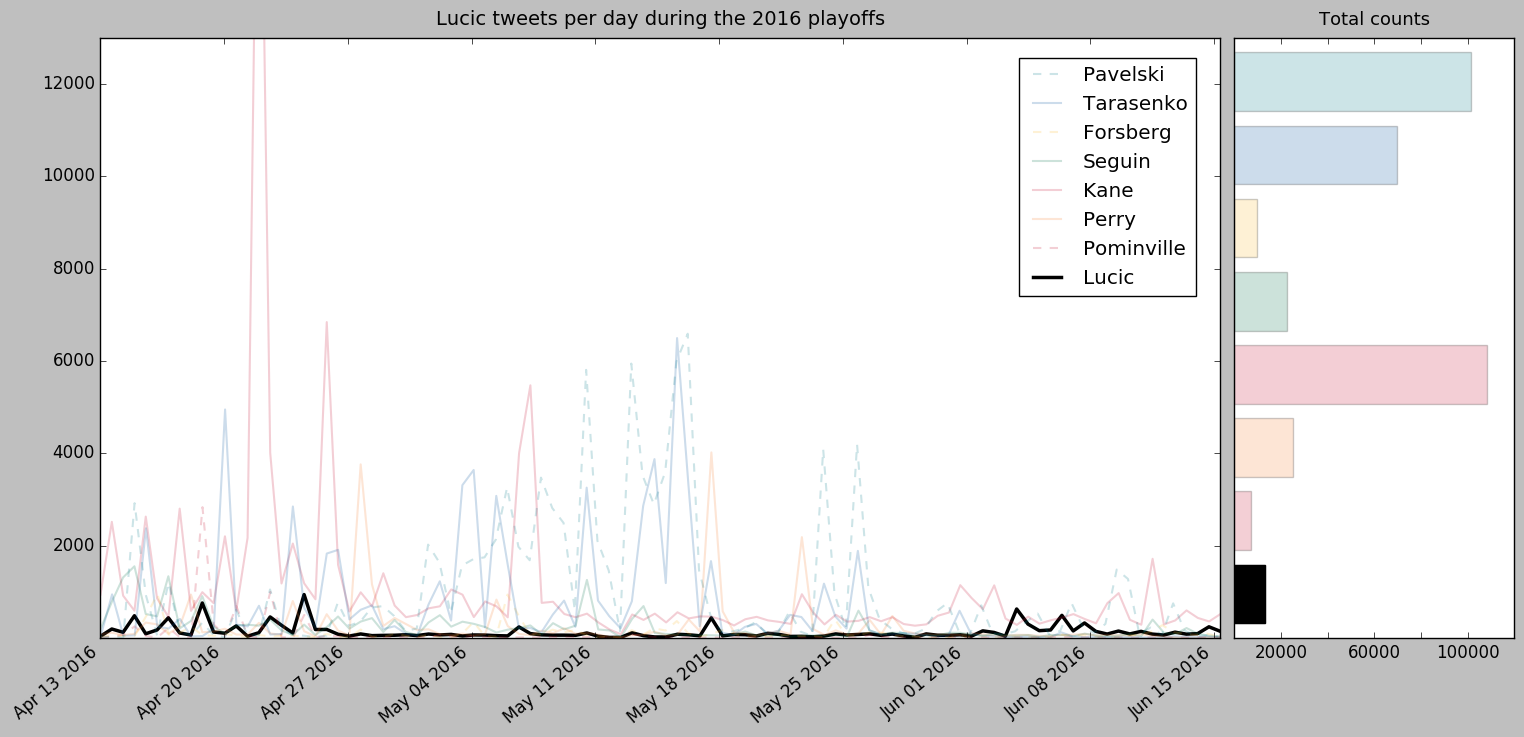

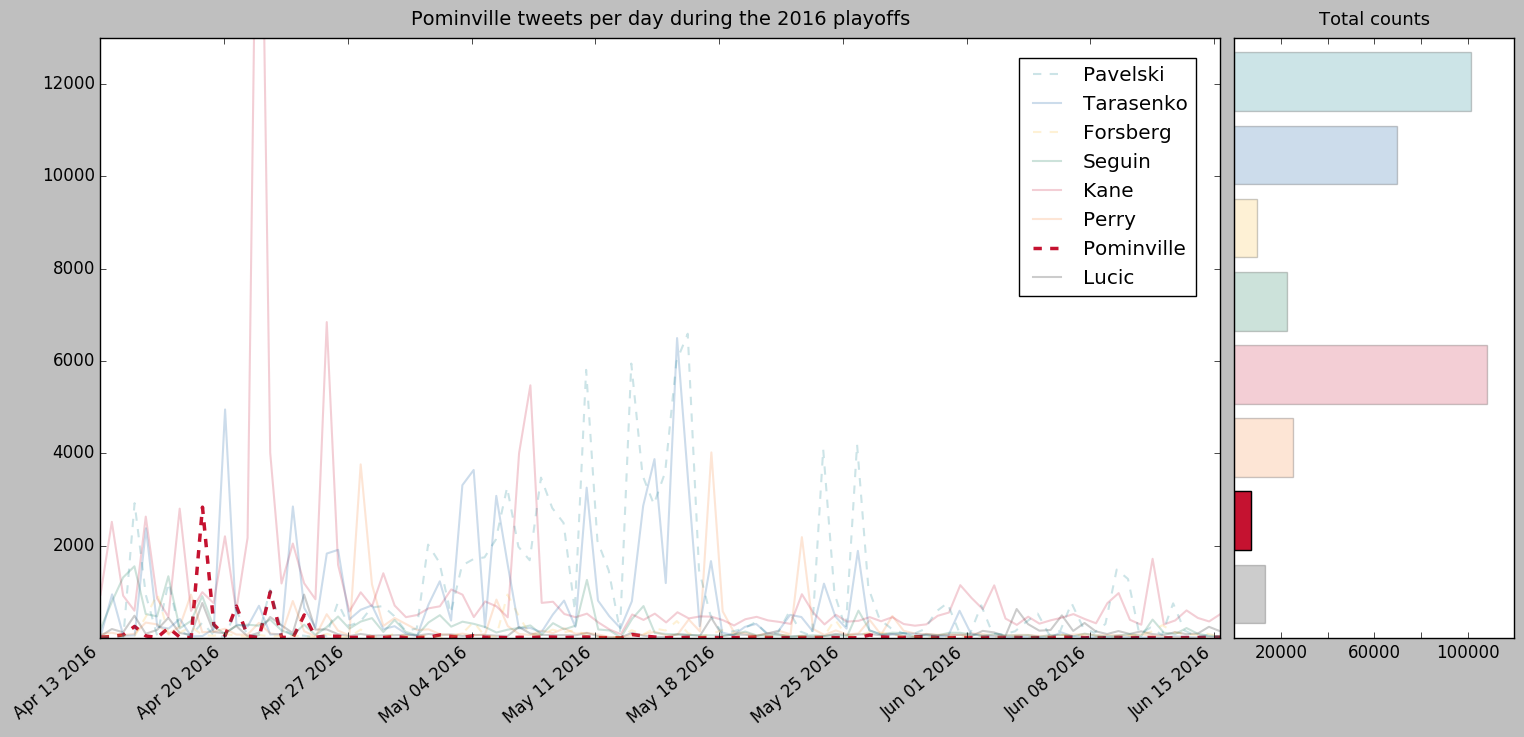

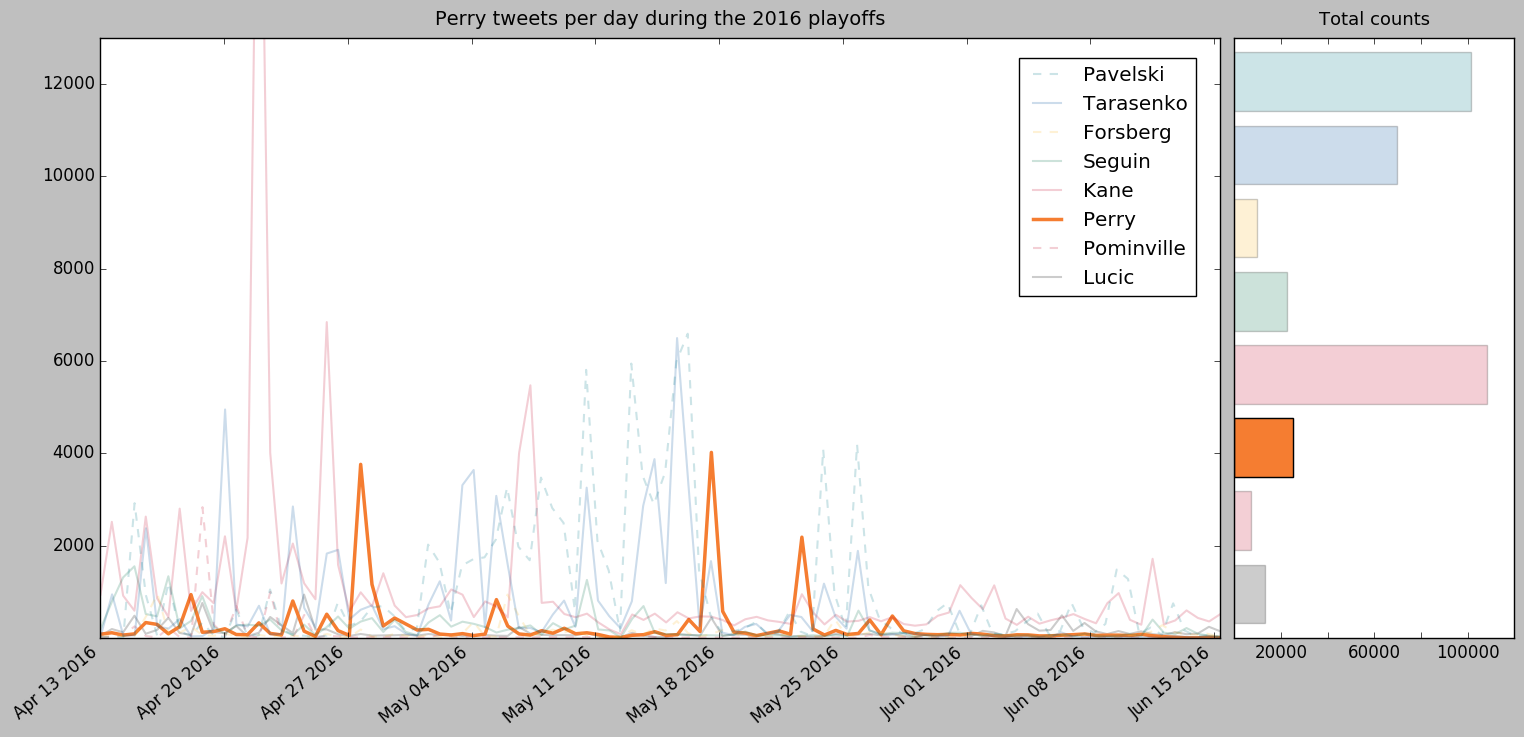

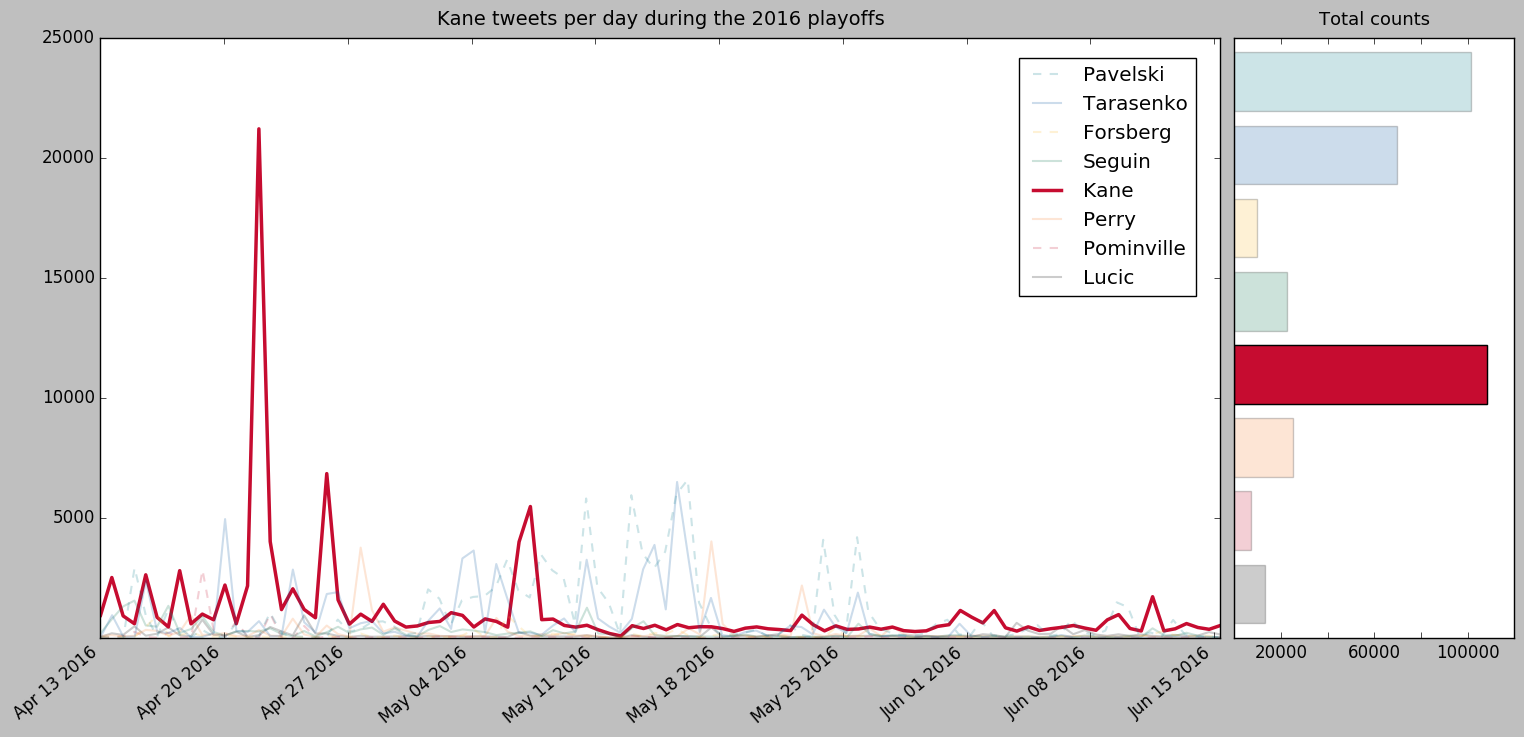

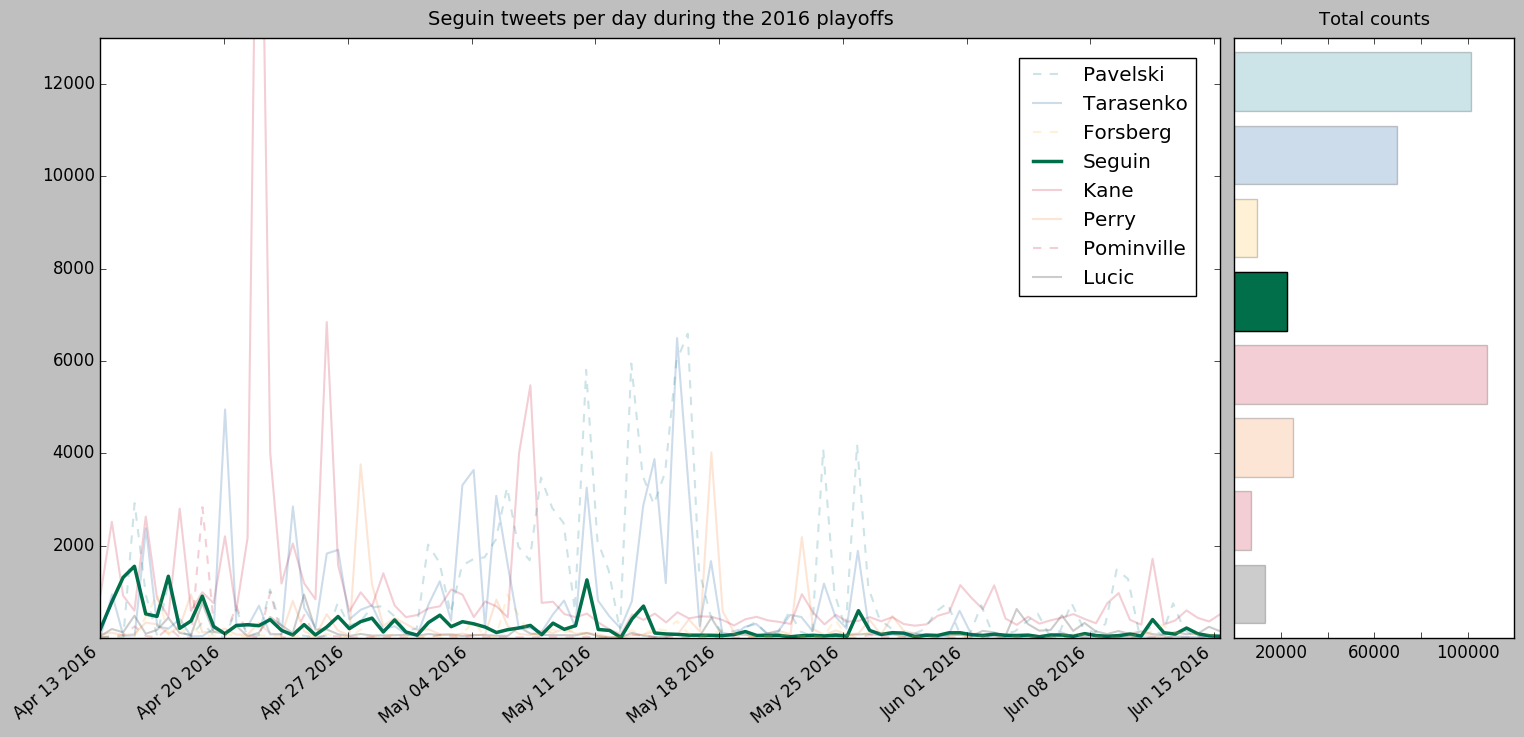

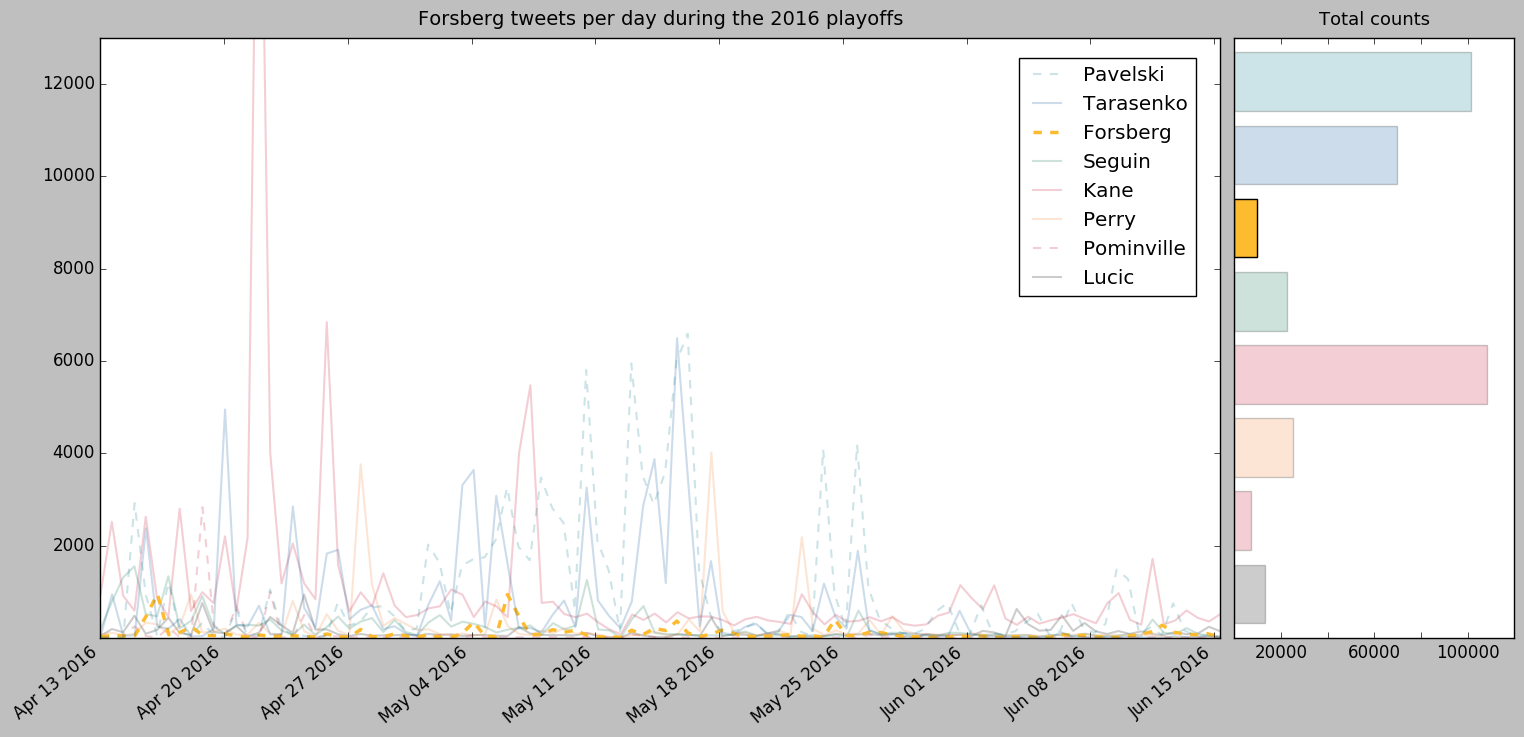

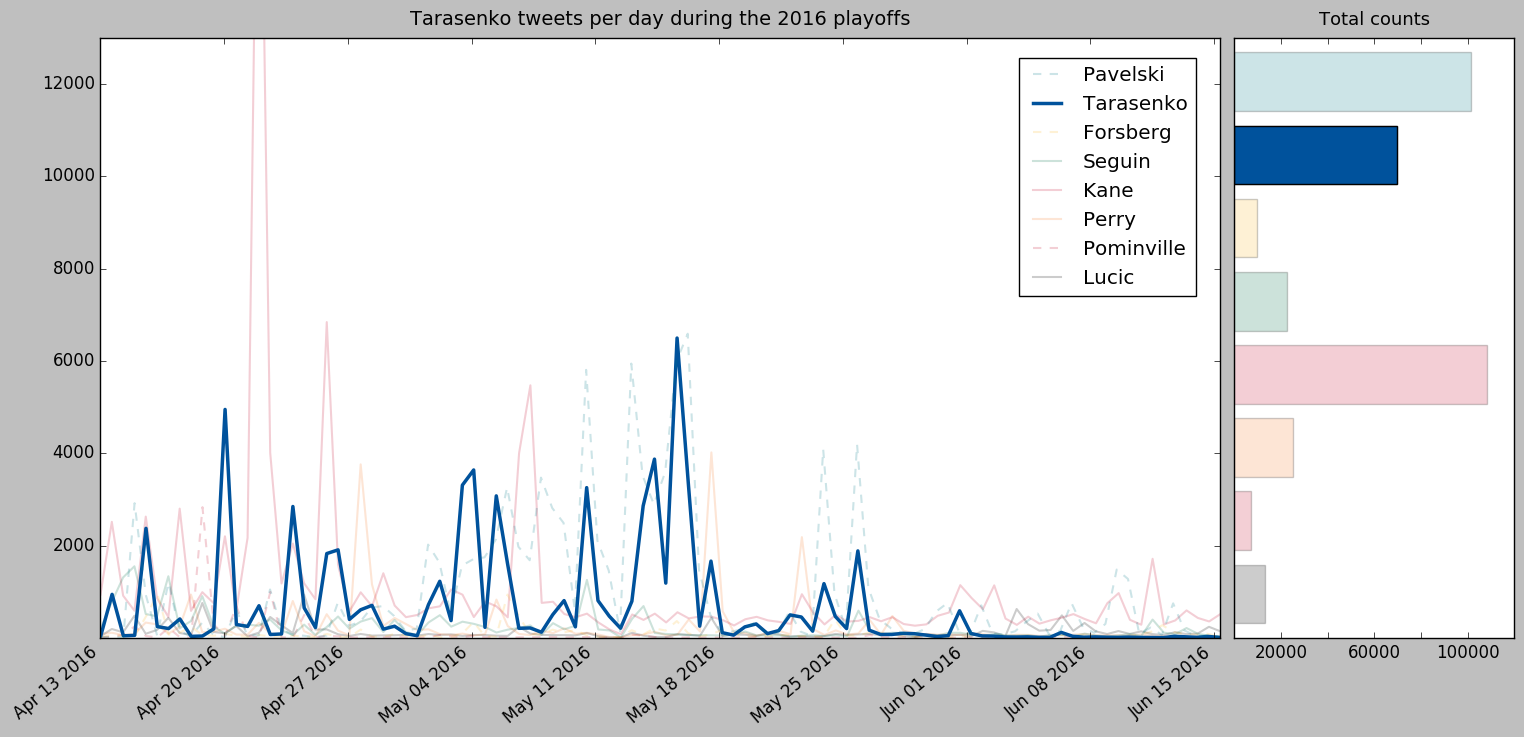

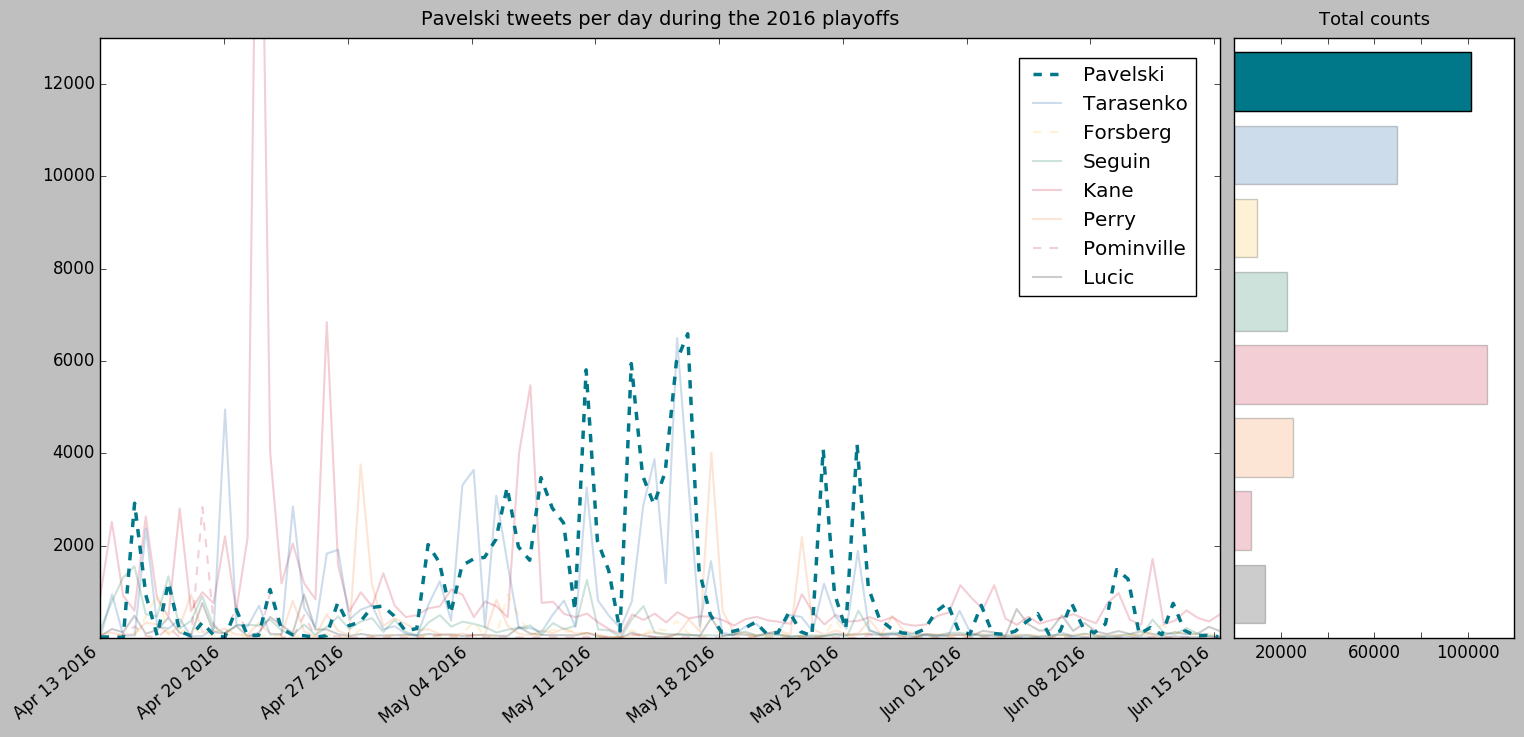

In [388]:
for ip, p in enumerate(west_players):
    fig = plt.figure(figsize=(14,6))
    for i, player in enumerate(west_players):
        left, bottom, width, height = [0.0, 0.0, 0.8, 1.0]
        ax = fig.add_axes([left, bottom, width, height])
        if p != player:
            if player == 'Pavelski' or player == 'Forsberg' or player == 'Pominville':
                ax.plot(my_hist_times[player], my_hists[player][0],
                        label=player, linestyle='--', alpha=0.2,
                        color=colors_dict[player], linewidth=1.5)
            else:
                ax.plot(my_hist_times[player], my_hists[player][0],
                        label=player, alpha=0.2,
                        color=colors_dict[player], linewidth=1.5)
            if p != 'Kane':
                ax.set_ylim(0, 13000)
            tks = ax.xaxis.get_majorticklabels()
            for tick in tks:
                tick.set_horizontalalignment('right')
            plt.setp(tks, rotation=40)
        else:
            if player == 'Pavelski' or player == 'Forsberg' or player == 'Pominville':
                ax.plot(my_hist_times[p], my_hists[p][0],
                        color=colors_dict[p], linewidth=2.5,
                        label=p, linestyle='--')
            else:
                ax.plot(my_hist_times[p], my_hists[p][0],
                        color=colors_dict[p], linewidth=2.5,
                        label=p)
            if p != 'Kane':
                ax.set_ylim(0, 13000)
            tks = ax.xaxis.get_majorticklabels()
            for tick in tks:
                tick.set_horizontalalignment('right')
            plt.setp(tks, rotation=40)
        for lab in ax.get_yticklabels():
            lab.set_visible(False)
            break

    
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1], loc=(0.82, 0.57))
    ax.set_title(p+' tweets per day during the 2016 playoffs', y=1.01, fontsize=14)
    
    left, bottom, width, height = [0.81, 0.0, 0.2, 1.0]
    ax_bar = fig.add_axes([left, bottom, width, height])
    ax_bar.barh(range(8), [sum(my_hists[p][0]) for p in west_players],
                color=[colors_dict[p] for p in west_players], alpha=0.2)
    ax_bar.barh(ip, sum(my_hists[p][0]), color=colors_dict[p])
    ax_bar.set_yticks([])
    ax_bar.set_yticklabels([])
    ax_bar.set_ylim(-0.2, 8)
    ax_bar.set_title('Total counts', y=1.01, fontsize=13)
    for label in ax_bar.get_xticklabels()[::2]:
        label.set_visible(False)
        
    plt.savefig('figures/west_players/'+p+'.png', bbox_inches='tight', dpi=144)
        
    plt.show()

### Most influential twitter users
Determine influnce based on number of favorites + retweets on all original tweets. Also look at users who post the most and the highest post/(likes + retweets) ratio.

In [48]:
df_originals = df[(df.RT == False)]
df_originals.head()

created_at  favorite_count  followers_count  friends_count  \
7  2016-04-13 23:58:10               0              745            445   
11 2016-04-13 23:57:19               1              885            678   
16 2016-04-13 23:56:42               1              740            582   
17 2016-04-13 23:56:37               0              339             93   
18 2016-04-13 23:56:35               1              801            513   

    retweet_count      screen_name search_phrase  \
7               0  AlisonWonderlan          Kane   
11              0       MarkBooone          Kane   
16              0  WingWheelWonder          Kane   
17              0      TrevorTiern          Kane   
18              2        _morgiiie          Kane   

                                                 text     RT  
7   Just spent way too much time in the bathroom a...  False  
11                         Patrick Kane's commercial😂  False  
16          Patrick Kane has the Donald Trump tan LOL  False  
17                   Patrick Kane is not a role model  False  
18  ain't no body like Patrick Kane get him outta ...  False

In [49]:
unique_names = np.unique(df_originals.screen_name)
all_users = {'influence': {user: 0 for user in unique_names},
             'count': dict(Counter(df_originals.screen_name))}

In [50]:
for user, L, R in zip(df_originals.screen_name,
                      df_originals.favorite_count,
                      df_originals.retweet_count):
    all_users['influence'][user] += (L + R)

In [51]:
all_users['ratio'] = {user: all_users['influence'][user]/all_users['count'][user] for user in unique_names}

In [52]:
# For sorting lists of tuples
import operator

sorted_users = {}
for key in all_users.keys():
    sorted_users[key] = sorted(all_users[key].items(), key=operator.itemgetter(1))[::-1]

In [53]:
for key in sorted_users.keys():
    print(key)
    print(np.array(sorted_users[key]).shape)

influence
(109764, 2)
count
(109764, 2)
ratio
(109764, 2)


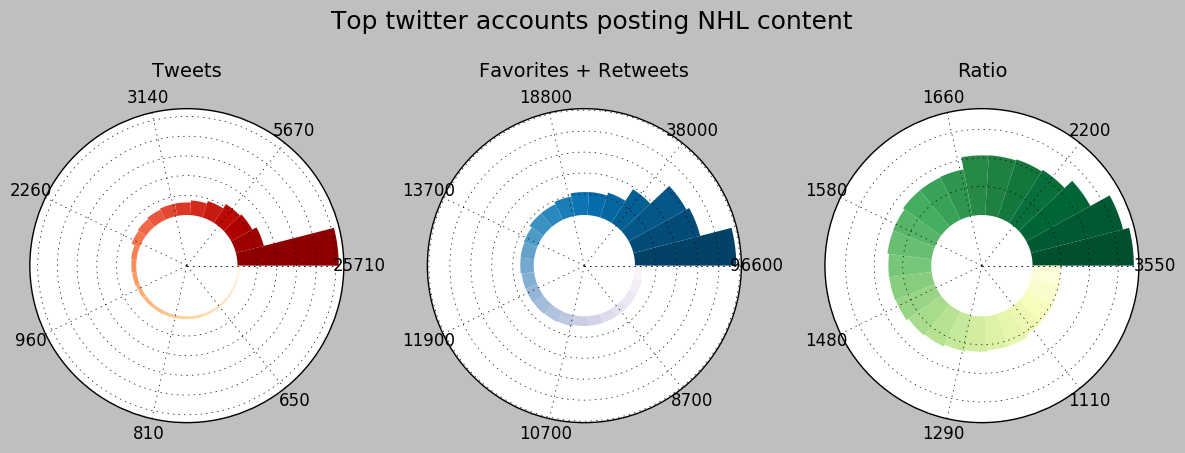

In [72]:
fig = plt.figure(figsize=(12, 8))

N = 25 # len(sorted_users['count'])

c1 = sns.color_palette("OrRd", N)
c2 = sns.color_palette("PuBu", N)
c3 = sns.color_palette("YlGn", N)




ax = plt.subplot(131, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['count'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c1[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(round(y[int(x/np.pi/2*N)], -1)) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Tweets', y=1.08, fontsize=14)




ax = plt.subplot(132, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['influence'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c2[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(round(y[int(x/np.pi/2*N)], -2)) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Favorites + Retweets', y=1.08, fontsize=14)




ax = plt.subplot(133, projection='polar')
x = np.linspace(0, 2*np.pi, N+1)[:-1]
y = [sorted_users['ratio'][i][1] for i in range(N)]
#y = np.log(y)
ax.bar(x, y, width=2*np.pi/N, color=c3[::-1], linewidth=0)

xtks = np.linspace(0, 2*np.pi, 8)
ax.set_xticks(xtks)
ax.set_xticklabels([str(int(round(y[int(x/np.pi/2*N)], -1))) for x in xtks[:-1]])
#ax.set_xticklabels([str(round(np.exp(y[int(x/np.pi/2*N)]), 0)) for x in xtks[:-1]])
ax.set_yticklabels([])
ax.set_ylim(-max(y)/2, max(y)*1.05)
ax.set_title('Ratio', y=1.08, fontsize=14)




plt.tight_layout()
plt.suptitle('Top twitter accounts posting NHL content', y=0.82, fontsize=18)
plt.savefig('figures/count_influence_ratio_circles.png', bbox_inches='tight', dpi=144)
plt.show()

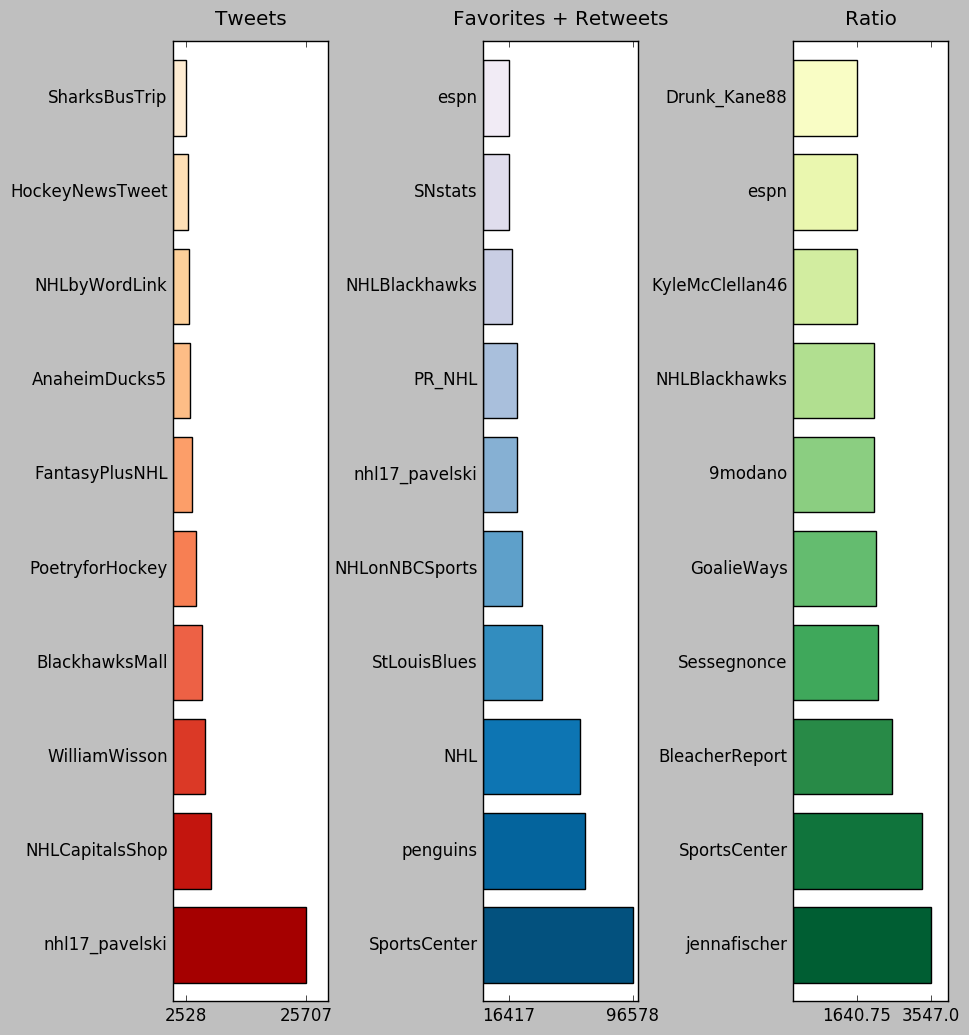

In [183]:
fig = plt.figure(figsize=(10, 12))

N = 10

c1 = sns.color_palette("OrRd", N)
c2 = sns.color_palette("PuBu", N)
c3 = sns.color_palette("YlGn", N)

ax = plt.subplot(131)
x = np.arange(0, 10, 1)
y = [sorted_users['count'][i][1] for i in range(10)]
ax.barh(x, y, color=c1[::-1])
ax.set_title('Tweets', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['count'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)

ax = plt.subplot(132)
x = np.arange(0, 10, 1)
y = [sorted_users['influence'][i][1] for i in range(10)]
ax.barh(x, y, color=c2[::-1])
ax.set_title('Favorites + Retweets', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['influence'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)

ax = plt.subplot(133)
x = np.arange(0, 10, 1)
y = [sorted_users['ratio'][i][1] for i in range(10)]
ax.barh(x, y, color=c3[::-1])
ax.set_title('Ratio', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels([sorted_users['ratio'][i][0] for i in range(10)])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)

plt.subplots_adjust(wspace=1.0)

plt.savefig('figures/count_influence_ratio_bar.png', bbox_inches='tight', dpi=144)
plt.show()

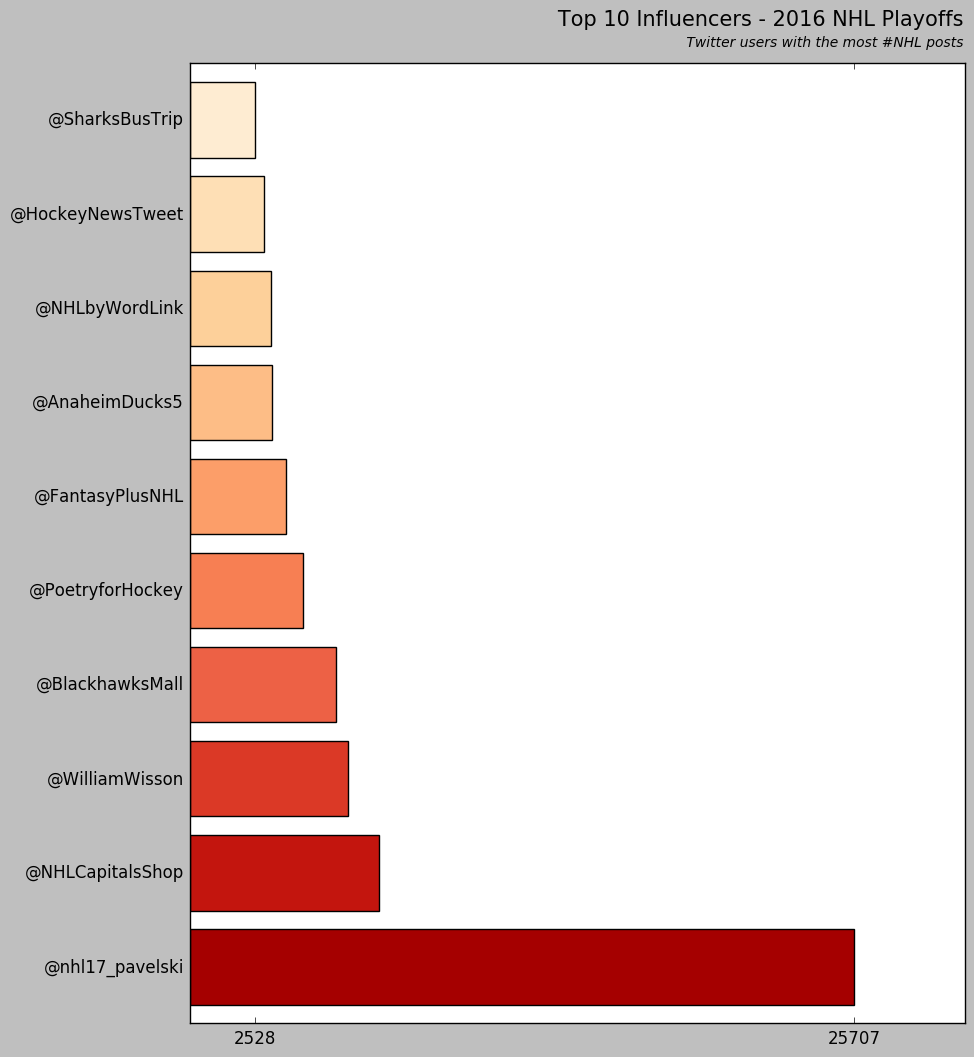

In [194]:
fig = plt.figure(figsize=(10, 12))

N = 10

c1 = sns.color_palette("OrRd", N)
c2 = sns.color_palette("PuBu", N)
c3 = sns.color_palette("YlGn", N)

ax = fig.add_subplot(111)
x = np.arange(0, 10, 1)
y = [sorted_users['count'][i][1] for i in range(10)]
ax.barh(x, y, color=c1[::-1])
ax.set_title('', y=1.01)
ax.set_yticks(x+0.4)
ax.set_yticklabels(['@'+user for user in [sorted_users['count'][i][0] for i in range(10)]])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)

ax.set_title('                                                                                                                 Twitter users with the most #NHL posts',
             style='italic', y=1.01, fontdict=font_dict, fontsize=10)
plt.suptitle('                                                           Top 10 Influencers - 2016 NHL Playoffs', y=0.945, fontsize=15)



plt.subplots_adjust(wspace=1.0)

plt.savefig('figures/count_bar.png', bbox_inches='tight', dpi=144)
plt.show()

In [177]:
y[0]

96578

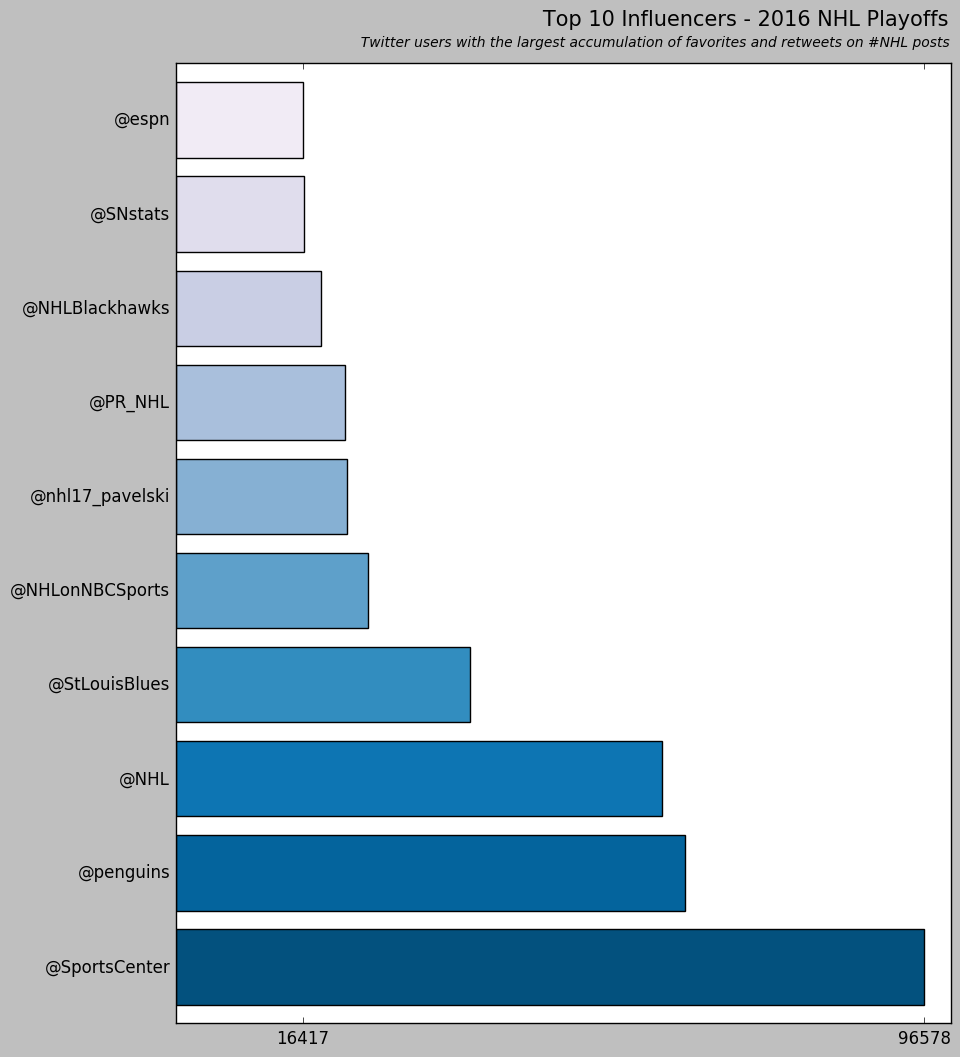

In [203]:
fig = plt.figure(figsize=(10, 12))

N = 10

c1 = sns.color_palette("OrRd", N)
c2 = sns.color_palette("PuBu", N)
c3 = sns.color_palette("YlGn", N)

font_dict = {'verticalalignment': 'baseline', 
             'horizontalalignment': 'center'}

ax = fig.add_subplot(111)
x = np.arange(0, 10, 1)
y = [sorted_users['influence'][i][1] for i in range(10)]
ax.barh(x, y, color=c2[::-1])
ax.set_title('                                          Twitter users with the largest accumulation of favorites and retweets on #NHL posts',
             style='italic', y=1.01, fontdict=font_dict, fontsize=10)
ax.set_yticks(x+0.4)
ax.set_yticklabels(['@'+user for user in [sorted_users['influence'][i][0] for i in range(10)]])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)
plt.suptitle('                                                           Top 10 Influencers - 2016 NHL Playoffs', y=0.945, fontsize=15)

plt.subplots_adjust(wspace=1.0)

plt.savefig('figures/influence_bar.png', bbox_inches='tight', dpi=144)
plt.show()

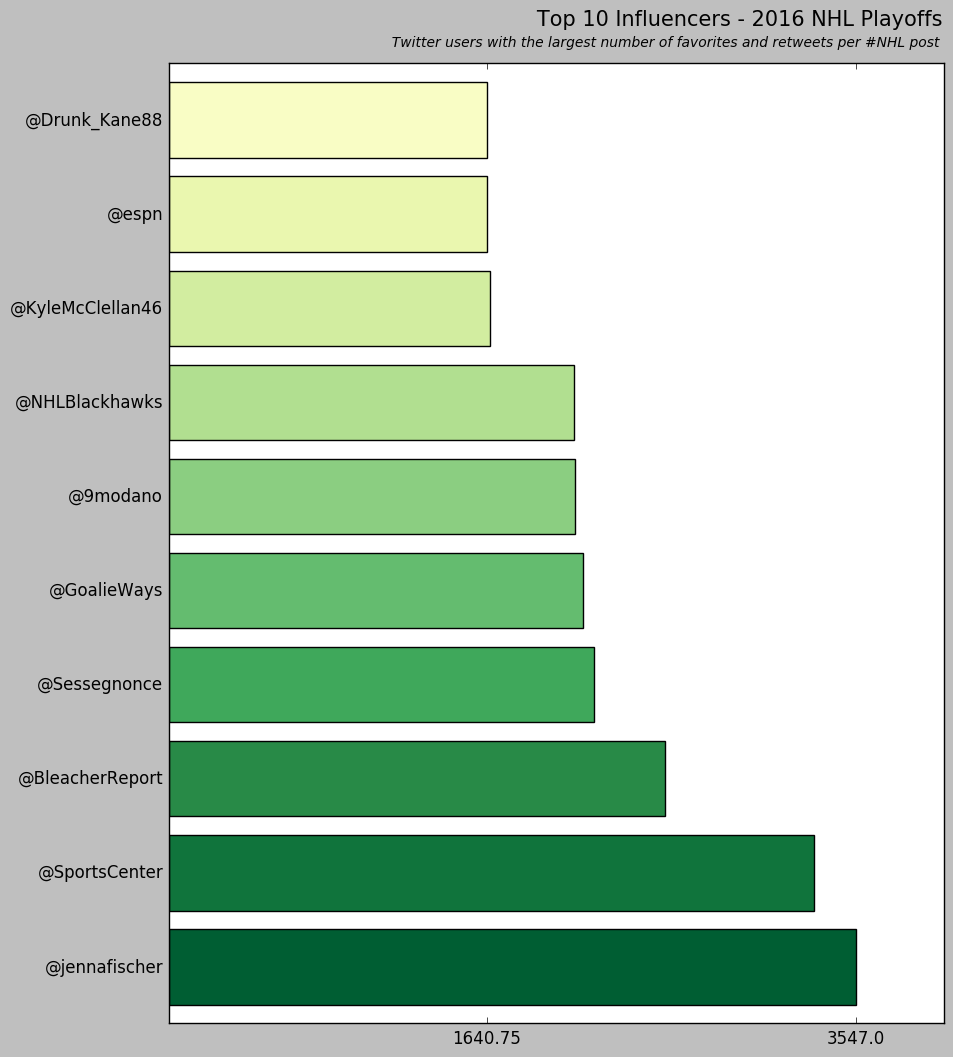

In [205]:
fig = plt.figure(figsize=(10, 12))

N = 10

c1 = sns.color_palette("OrRd", N)
c2 = sns.color_palette("PuBu", N)
c3 = sns.color_palette("YlGn", N)

font_dict = {'verticalalignment': 'baseline', 
             'horizontalalignment': 'center'}

ax = fig.add_subplot(111)
x = np.arange(0, 10, 1)
y = [sorted_users['ratio'][i][1] for i in range(10)]
ax.barh(x, y, color=c3[::-1])
ax.set_title('                                                  Twitter users with the largest number of favorites and retweets per #NHL post',
             style='italic', y=1.01, fontdict=font_dict, fontsize=10)
ax.set_yticks(x+0.4)
ax.set_yticklabels(['@'+user for user in [sorted_users['ratio'][i][0] for i in range(10)]])
ax.set_ylim(-0.2, 10)
ax.set_xticks([y[0], y[9]])
ax.set_xticklabels([y[0], y[9]])
plt.setp(ax.get_yticklines(), visible=False)
plt.suptitle('                                                           Top 10 Influencers - 2016 NHL Playoffs', y=0.945, fontsize=15)

plt.subplots_adjust(wspace=1.0)

plt.savefig('figures/ratio_bar.png', bbox_inches='tight', dpi=144)
plt.show()

#### Most popular tweets about each player

In [75]:
df_originals['influence'] = df_originals['favorite_count'] + df_originals['retweet_count']

C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [76]:
pop_tweets = {}
for player in all_players:
    top_tweet = df_originals[(df_originals.search_phrase == player)].sort_values(by='influence', ascending=False).iloc[0,:]
    pop_tweets[player] = [top_tweet.text, top_tweet.favorite_count, top_tweet.retweet_count]
pop_tweets

{'Crosby': ['With 19 points (6G-13A), your 2016 Conn Smythe winner is, Sidney Crosby! https://t.co/Intt6grdz0',
  7694,
  4855],
 'Forsberg': ['Ryan Johansen and Filip Forsberg fall over the boards at the same time while celebrating a goal 😂😂 \nhttps://t.co/3Su1XeRkxF',
  2145,
  1244],
 'Giroux': ['Claude Giroux is better than Sidney Cro- https://t.co/Zv7589oAiu',
  919,
  313],
 'Jagr': ['44-year-old Jaromir Jagr is returning to the Panthers after agreeing on 1-year contract. It will be his 23rd season. https://t.co/on8lEVps6E',
  5522,
  2580],
 'Kane': ['Congrats to Patrick Kane on being named a finalist for the 2016 Hart Memorial Trophy! \n\n#SHOWTIME https://t.co/CJQNVJfZNF',
  5161,
  1898],
 'Kucherov': ['Tampa Bay takes the series opener, defeating the Red Wings, 3-2. \n\nNikita Kucherov: 2 G, 1 A https://t.co/6f7a2kVsLM',
  1512,
  840],
 'Lucic': ["Lucic *very* much wants to remain in Los Angeles. Talks progressing; he indicated that they're not worlds apart.",
  420,
  167]

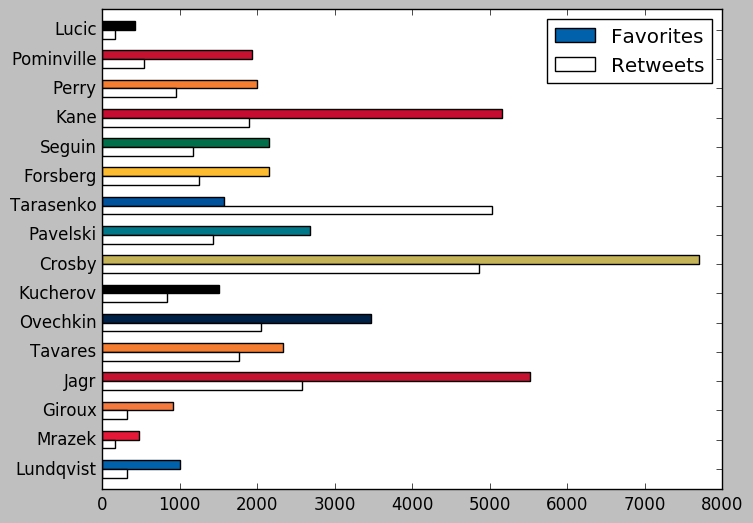

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors = [colors_dict[p] for p in all_players]

x1 = np.arange(0, len(all_players), 1)
x2 = x1 - 0.3

# y1 = likes
y1 = [pop_tweets[p][1] for p in all_players]
# y2 = retweets
y2 = [pop_tweets[p][2] for p in all_players]

ax.barh(x1, y1, color=colors, height=0.3, label='Favorites')
ax.barh(x2, y2, color='white', height=0.3, label='Retweets')

ax.set_yticks(x1)
ax.set_yticklabels([p for p in all_players])
ax.set_ylim(-0.7, 15.7)
plt.legend()

plt.savefig('figures/most_influential_tweets', bbox_inches='tight', dpi=144)

plt.show();

In [78]:
pop_tweets = {}
for player in all_players:
    top_tweet = df_originals[(df_originals.search_phrase == player)].sort_values(by='favorite_count', ascending=False).iloc[0,:]
    pop_tweets[player] = [top_tweet.text, top_tweet.favorite_count, top_tweet.retweet_count]
pop_tweets

{'Crosby': ['With 19 points (6G-13A), your 2016 Conn Smythe winner is, Sidney Crosby! https://t.co/Intt6grdz0',
  7694,
  4855],
 'Forsberg': ['Ryan Johansen and Filip Forsberg fall over the boards at the same time while celebrating a goal 😂😂 \nhttps://t.co/3Su1XeRkxF',
  2145,
  1244],
 'Giroux': ['Claude Giroux is better than Sidney Cro- https://t.co/Zv7589oAiu',
  919,
  313],
 'Jagr': ['44-year-old Jaromir Jagr is returning to the Panthers after agreeing on 1-year contract. It will be his 23rd season. https://t.co/on8lEVps6E',
  5522,
  2580],
 'Kane': ['Congrats to Patrick Kane on being named a finalist for the 2016 Hart Memorial Trophy! \n\n#SHOWTIME https://t.co/CJQNVJfZNF',
  5161,
  1898],
 'Kucherov': ['Tampa Bay takes the series opener, defeating the Red Wings, 3-2. \n\nNikita Kucherov: 2 G, 1 A https://t.co/6f7a2kVsLM',
  1512,
  840],
 'Lucic': ["Lucic *very* much wants to remain in Los Angeles. Talks progressing; he indicated that they're not worlds apart.",
  420,
  167]

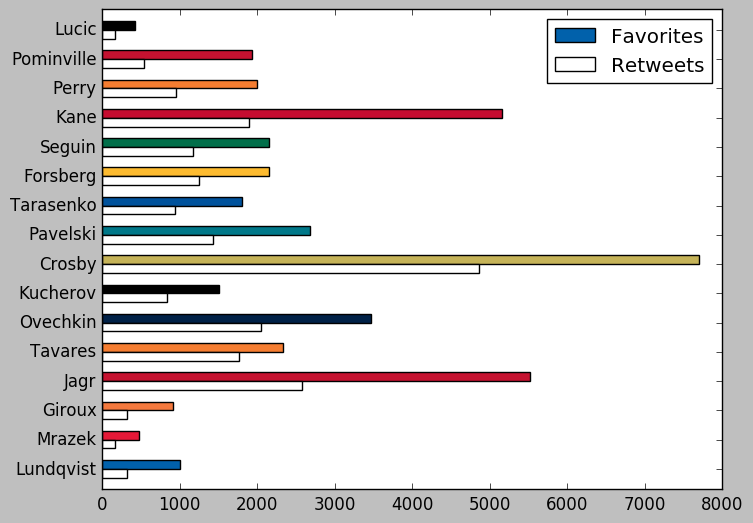

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)

colors = [colors_dict[p] for p in all_players]

x1 = np.arange(0, len(all_players), 1)
x2 = x1 - 0.3

# y1 = likes
y1 = [pop_tweets[p][1] for p in all_players]
# y2 = retweets
y2 = [pop_tweets[p][2] for p in all_players]

ax.barh(x1, y1, color=colors, height=0.3, label='Favorites')
ax.barh(x2, y2, color='white', height=0.3, label='Retweets')

ax.set_yticks(x1)
ax.set_yticklabels([p for p in all_players])
ax.set_ylim(-0.7, 15.7)
plt.legend()

plt.savefig('figures/most_favorited_tweets', bbox_inches='tight', dpi=144)

plt.show();

### Machine learning application
Try and guess average number of likes + retweets (categorically i.e. a classification problem) given the number of followers and following

In [ ]:
df.columns

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.friends_count.values, df.followers_count.values,
            df.favorite_count.values+df.retweet_count.values)
plt.show()

This doesn't look promising ... let's split up the data into categories and re-plot with different symbols/colors instead of a third axes.

#### Make a histogram of `df.influence` = likes + retweets

In [206]:
df_originals.head(1)

created_at  favorite_count  followers_count  friends_count  \
7 2016-04-13 23:58:10               0              745            445   

   retweet_count      screen_name search_phrase  \
7              0  AlisonWonderlan          Kane   

                                                text     RT  influence  
7  Just spent way too much time in the bathroom a...  False          0

In [223]:
# Getting a warning because I'm copying on a 'slice' dataframe
# i.e., not a true copy
df_originals['influence'] = df_originals.iloc[:,1] + df_originals.iloc[:,4]

C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [224]:
df_originals.describe()

favorite_count  followers_count  friends_count  retweet_count      RT  \
count   367476.000000    367476.000000  367476.000000  367476.000000  367476   
mean         2.630697      9488.252830     942.491014       1.302586       0   
std         41.893443    301242.886628    4260.504337      25.790703       0   
min          0.000000         0.000000       0.000000       0.000000   False   
25%          0.000000        84.000000      73.000000       0.000000       0   
50%          0.000000       303.000000     298.000000       0.000000       0   
75%          1.000000       898.000000     838.000000       0.000000       0   
max       7694.000000  28759447.000000  344656.000000    5031.000000   False   

           influence  
count  367476.000000  
mean        3.933283  
std        65.599931  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max     12549.000000

In [225]:
x = df_originals.influence.values
x_log = np.log(df_originals.influence[df_originals.influence != 0]).values

#### Plot normalized histogram and cumulative sum

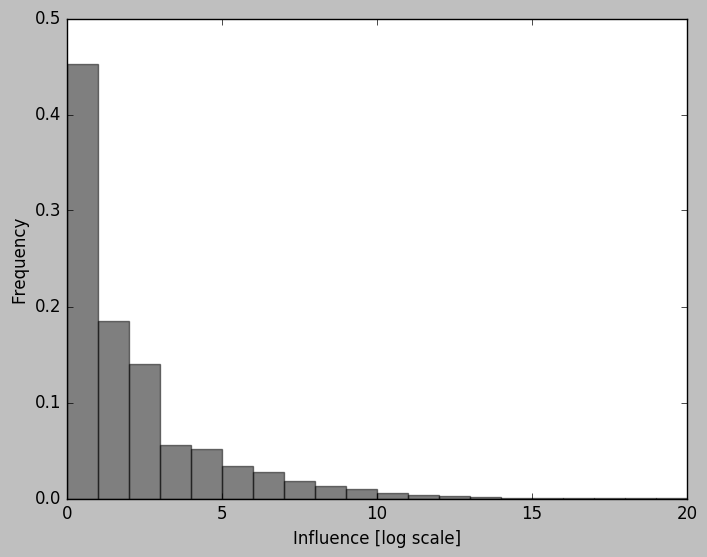

In [230]:
fig = plt.figure()

bins = 20

c2 = sns.color_palette("PuBu", bins)

ax = fig.add_subplot(111)

hist = np.histogram(x_log, bins=bins)

ax.bar(range(bins), hist[0]/sum(hist[0]), width=20/bins, color='black', alpha=0.5)

ax.set_ylim(0.0, 0.5)
ax.set_xlabel('Influence [log scale]')

ax.set_ylabel('Frequency')
plt.show()

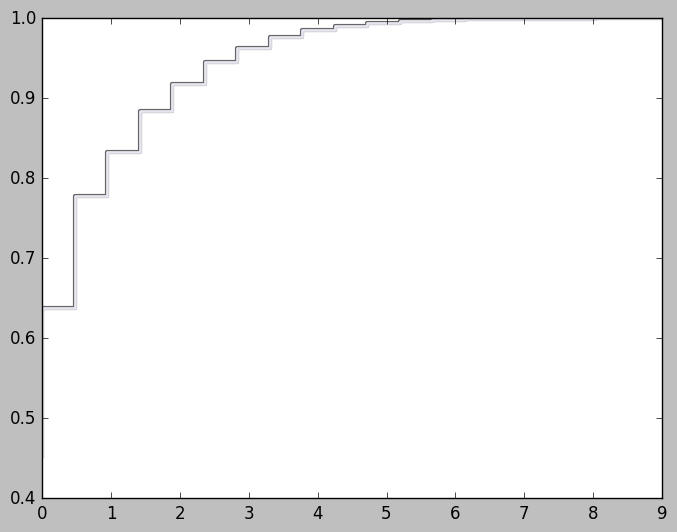

In [231]:
# Don't really trust this plot ...

fig = plt.figure()
ax = fig.add_subplot(111)

csum = np.cumsum(hist[0])
ax.step(hist[1][:-1], csum/csum.max(), color='black', lw=3, alpha=0.6)
ax.step(hist[1][:-1], csum/csum.max(), color=c2[2], lw=2)
plt.show()

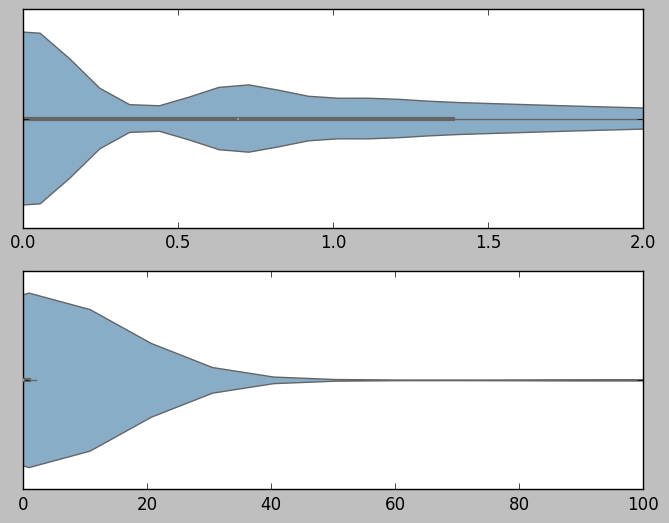

In [239]:
fig = plt.figure()

ax = fig.add_subplot(211)
ax = sns.violinplot(x_log[:20000], color=c2[9])
ax.set_xlim(0, 2)

ax = fig.add_subplot(212)
ax = ax = sns.violinplot(x[:500], color=c2[9])
ax.set_xlim(0, 100)

plt.savefig('figures/influence_violin.png', bbox_inches='tight', dpi=144)
plt.show()

We want minimal categories. Perhaps: none (0), low (1-5), moderate(6-15), high(16-100), famous(100+)

In [240]:
influence_map = {'None': 1, 'Low': 2,
                 'Moderate': 3, 'High': 4}
                 #'Famous': np.exp(hist[1][8])}
influence_map_inv = {k: v for v, k in influence_map.items()}
influence_map_inv

{1: 'None', 2: 'Low', 3: 'Moderate', 4: 'High'}

In [241]:
class_table = pd.DataFrame({'Class label': ['None', 'Low', 'Moderate', 'High'],
                            'Popularity = Favorites + Retweets': ['0', '1-2', '3-6', '6+']})
class_table

Class label Popularity = Favorites + Retweets
0        None                                 0
1         Low                               1-2
2    Moderate                               3-6
3        High                                6+

In [242]:
def influence_category(x):
    if x == 0:
        return 'None'
    elif x <= 2:
        return 'Low'
    elif x <= 6:
        return 'Moderate'
    elif x > 6:
        return 'High'

df_originals['influence_category'] = [influence_category(x) for x in df_originals.influence]
df_originals['influence_category'] = df_originals['influence_category'].map(influence_map).astype(int)

C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [243]:
# Any null values?

df_originals[df_originals.isnull().any(axis=1)]
# df_originals = df_originals.drop('influence_category')

Empty DataFrame
Columns: [created_at, favorite_count, followers_count, friends_count, retweet_count, screen_name, search_phrase, text, RT, influence, influence_category]
Index: []

In [244]:
df_originals.dtypes

created_at            datetime64[ns]
favorite_count                 int64
followers_count                int64
friends_count                  int64
retweet_count                  int64
screen_name                   object
search_phrase                 object
text                          object
RT                              bool
influence                      int64
influence_category             int32
dtype: object

In [245]:
c4 = ['blue', 'red', 'green', 'orange']

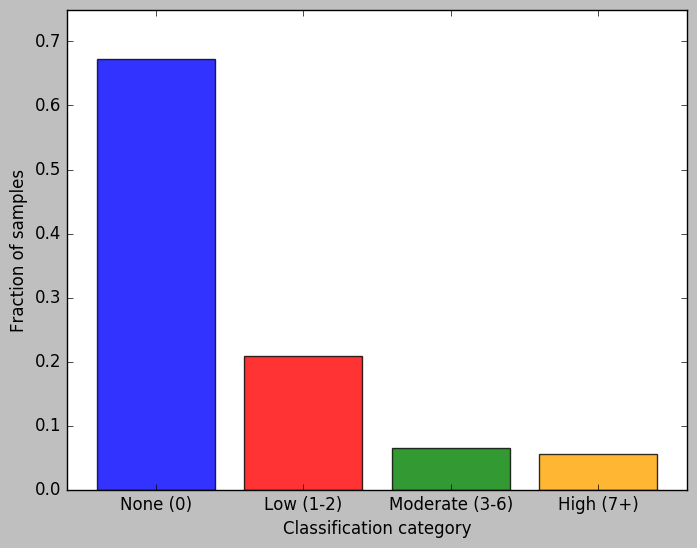

In [252]:
influence_hist = np.histogram(df_originals.influence_category.values, bins=len(np.unique(df_originals.influence_category)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(np.unique(df_originals.influence_category))), influence_hist[0]/sum(influence_hist[0]),
        alpha=0.8, color=c4)
ax.set_xlim(-0.2, 4)
ax.set_ylim(0, 0.75)
ax.set_xticks(np.array([0, 1, 2, 3])+0.4)
ax.set_xticklabels(['None (0)', 'Low (1-2)', 'Moderate (3-6)', 'High (7+)'])
ax.set_xlabel('Classification category')
ax.set_ylabel('Fraction of samples')
plt.savefig('figures/class_fractions.png', bbox_inches='tight', dpi=144)
plt.show()

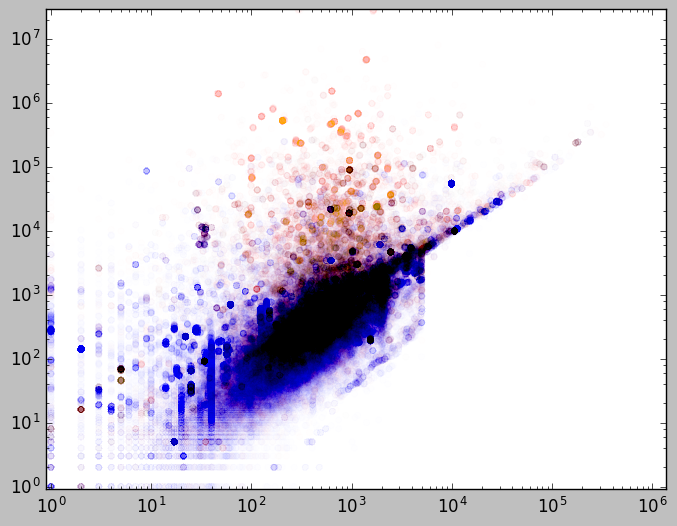

In [256]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df_originals.friends_count.values, df_originals.followers_count.values, color=[c4[i-1] for i in df_originals.influence_category],
           alpha=0.002)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(0.9, df.friends_count.max())
ax.set_ylim(0.9, df.followers_count.max())
plt.show()

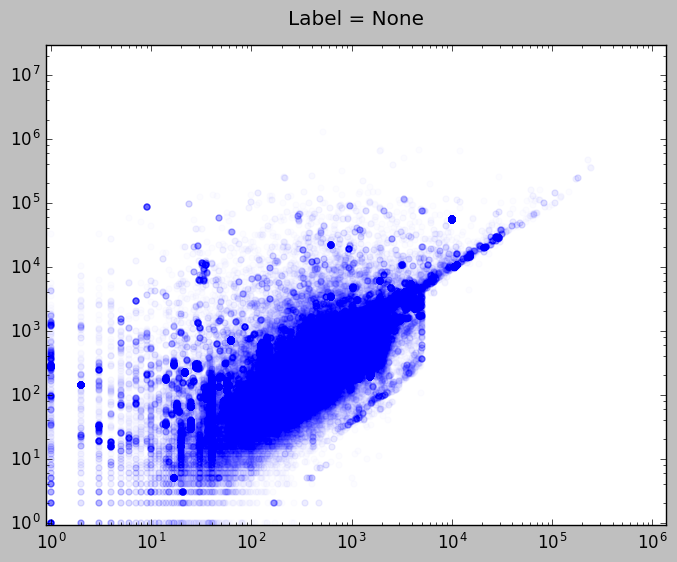

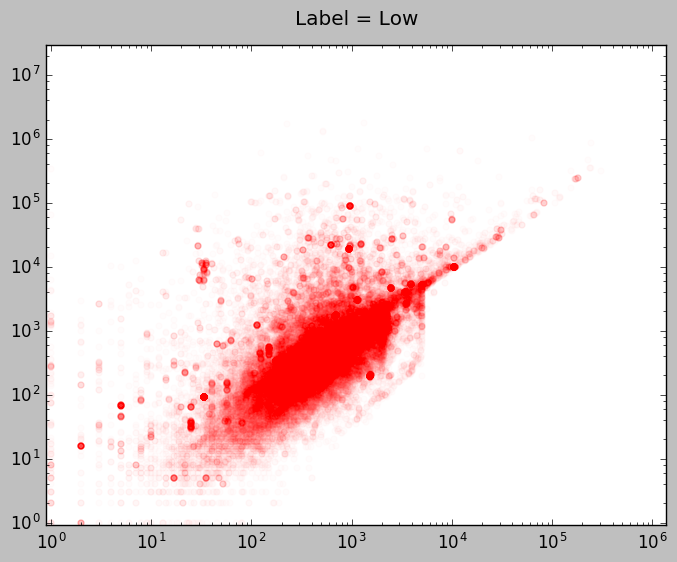

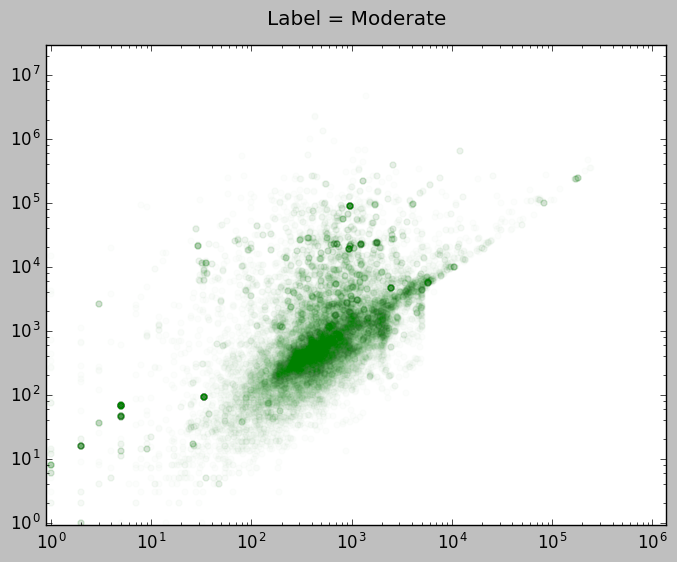

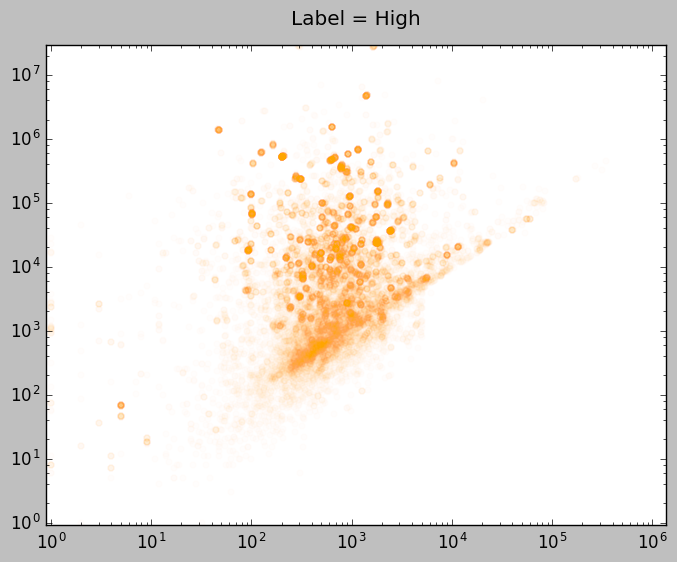

In [255]:
fig = plt.figure()
for i, y in enumerate(np.unique(df_originals.influence_category)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(df_originals[(df_originals['influence_category'] == y)].friends_count.values,
               df_originals[(df_originals['influence_category'] == y)].followers_count.values,
               color=c4[i], alpha=0.01)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(0.9, df.friends_count.max())
    ax.set_ylim(0.9, df.followers_count.max())
    ax.set_title('Label = '+influence_map_inv[y], y=1.03)
    plt.savefig('figures/influence_categories'+str(y)+'.png', bbox_inches='tight', dpi=144)
    plt.show()

In [ ]:
# x_all = np.vstack((df_originals.friends_count.values, df_originals.followers_count.values)).T

In [ ]:
# from scipy import stats

# def plot_kde(ax, samples):
#     x = np.linspace(0, df.friends_count.max(), 100)
#     y = np.linspace(0, df.followers_count.max(), 100)
#     X, Y = np.meshgrid(x, y)
#     xy = np.vstack([X.ravel(), Y.ravel()])
#     # sample_stack = np.vstack((samples.T[0].ravel(), samples.T[1].ravel())).T
#     kde = stats.gaussian_kde(samples)
#     z = kde(xy).T
#     Z = np.reshape(z, X.shape)
#     ax.imshow(np.rot90(Z), cmap=plt.cm.YlOrRd,
#               extent=[-1, 1, -1, 1])

# for i, y in enumerate(np.unique(df_originals.influence_category)):
#     if i==1:
#         break

#     x_kde = np.vstack((df_originals[(df_originals['influence_category'] == y)].friends_count.values,
#                        df_originals[(df_originals['influence_category'] == y)].followers_count.values)).T
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     plot_kde(ax, np.vstack({tuple(row) for row in x_kde})[::1000])
# #     ax.scatter(df_originals[(df_originals['influence_category'] == y)].friends_count.values,
# #                df_originals[(df_originals['influence_category'] == y)].followers_count.values,
# #                color=c4[i], alpha=0.1)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim(0.9, df.friends_count.max())
#     ax.set_ylim(0.9, df.followers_count.max())

#     plt.show()

In [ ]:
# x_kde = np.vstack((df_originals[(df_originals['influence_category'] == y)].friends_count.values,
#                    df_originals[(df_originals['influence_category'] == y)].followers_count.values)).T

# x_wtf = np.vstack({tuple(row) for row in x_kde})
# print(x_kde.shape)
# print(x_wtf.shape)

### kNN classifier

In [257]:
# Get training and testing data from dataframe

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_originals[['friends_count', 'followers_count']].values,
    df_originals['influence_category'].values,
    test_size = 0.3,
    random_state = 0)

In [260]:
StandardScaler?

In [258]:
# Standardize features

from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
std_sc.fit(X_train)
X_train_std = std_sc.transform(X_train)
X_test_std = std_sc.transform(X_test)

C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [293]:
# Adapted from Python Machine Learning book

from matplotlib.colors import ListedColormap

def plot_decision_regions(ax, X, y, classifier, l_dict, resolution=0.02, limits=[], plot_samples=True):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    if limits:
        x1_min, x1_max, x2_min, x2_max = limits
    else:
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    if limits:
        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
    else:
        ax.set_xlim(xx1.min(), xx1.max())
        ax.set_ylim(xx2.min(), xx2.max())

    # plot class samples
    if plot_samples:
        for idx, cl in enumerate(np.unique(y)):
            ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                       alpha=0.8, c=cmap(idx),
                       marker=markers[idx], label=l_dict[cl-1])

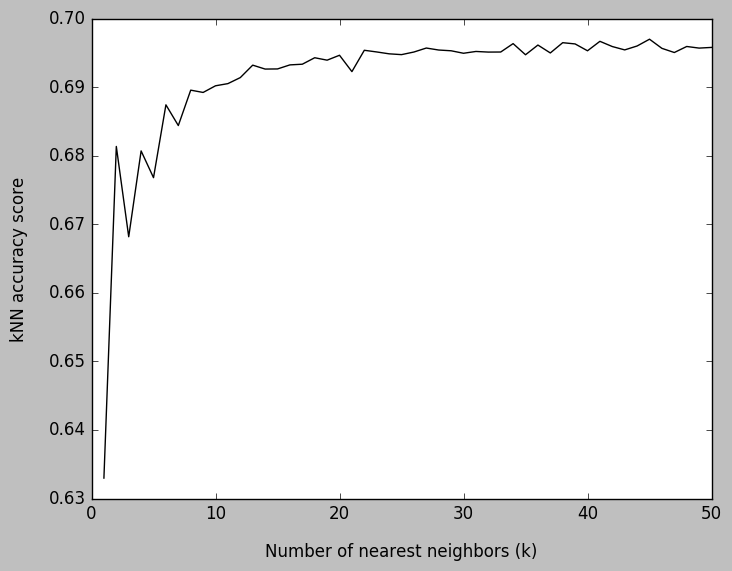

In [262]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

acc = []
N = 50
for n in range(1,N+1):
    knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)

    acc.append(accuracy_score(y_test, y_pred))
    
plt.plot(range(1,N+1), acc, color='black')
plt.ylabel('kNN accuracy score', labelpad=15)
plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
plt.show()

Let's look closer at k=50.

In [263]:
knn = KNeighborsClassifier(n_neighbors=50, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)

accuracy_score(y_test, y_pred)

0.69579927977286538

In [264]:
print('X')
print(X_train.shape)
print(X_test.shape)
print(np.vstack((X_train, X_test)).shape)

print('y')
print(y_train.shape)
print(y_test.shape)
print(np.hstack((y_train, y_test)).shape)

X
(257233, 2)
(110243, 2)
(367476, 2)
y
(257233,)
(110243,)
(367476,)


#### Only plotting 1 in 10 samples (training + test)

In [265]:
# Dictionary for labeling decision region plots
l_dict = ['None', 'Low', 'Moderate', 'High']

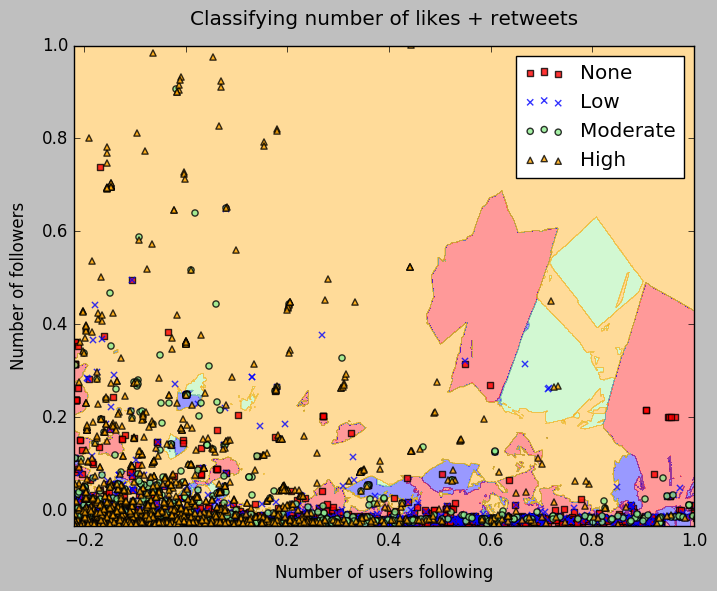

In [269]:
fig = plt.figure()
ax = fig.add_subplot(111)
limits = [-0.22, 1.0, -0.033, 1.0]

plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001, limits=limits)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(-0.185, limits[1])
# ax.set_ylim(-0.03275, 0.09)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_0.png', bbox_inches='tight', dpi=144)

plt.show()

C:\Anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


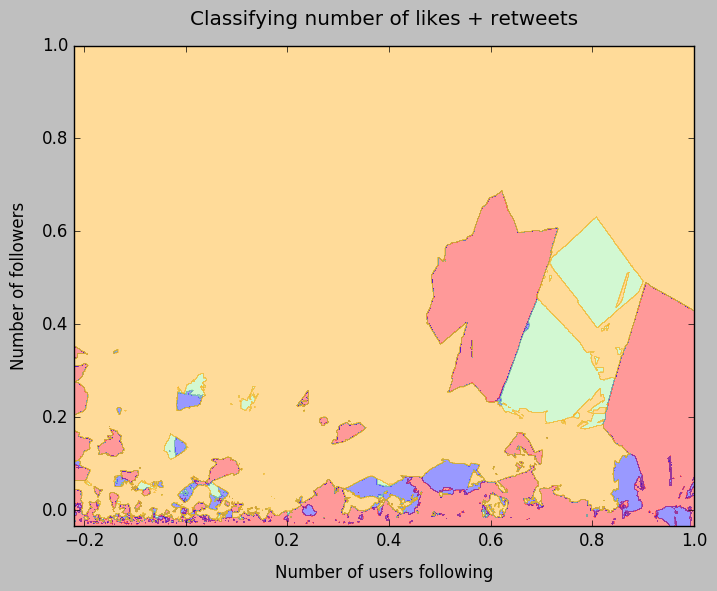

In [295]:
fig = plt.figure()
ax = fig.add_subplot(111)
limits = [-0.22, 1.0, -0.033, 1.0]

plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001, limits=limits,
                      plot_samples=False)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(-0.185, limits[1])
# ax.set_ylim(-0.03275, 0.09)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_0_no_samples.png', bbox_inches='tight', dpi=144)

plt.show()

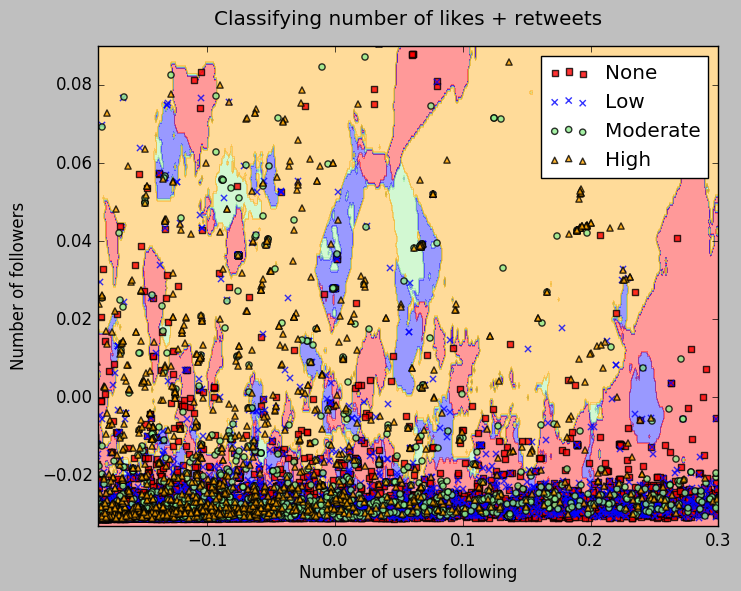

In [270]:
fig = plt.figure()
ax = fig.add_subplot(111)
limits = [-0.22, 0.3, -0.033, 0.1]
plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001, limits=limits)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(-0.185, limits[1])
ax.set_ylim(-0.03275, 0.09)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_1.png', bbox_inches='tight', dpi=144)

plt.show()

C:\Anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


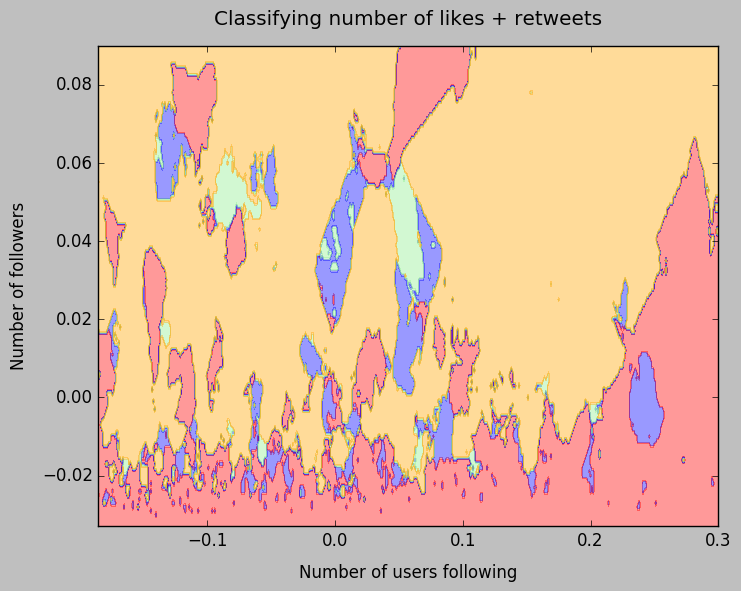

In [296]:
fig = plt.figure()
ax = fig.add_subplot(111)
limits = [-0.22, 0.3, -0.033, 0.1]
plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001, limits=limits,
                      plot_samples=False)
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(-0.185, limits[1])
ax.set_ylim(-0.03275, 0.09)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_1_no_samples.png', bbox_inches='tight', dpi=144)

plt.show()

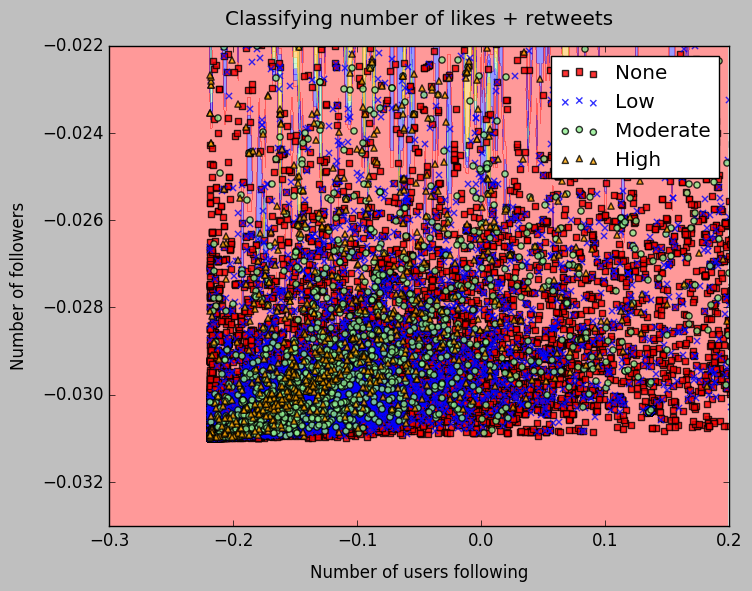

In [289]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001,
                      limits=[-0.3, 0.2, -0.033, -0.022])
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.0327, -0.022)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_2.png', bbox_inches='tight', dpi=144)

plt.show()

C:\Anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


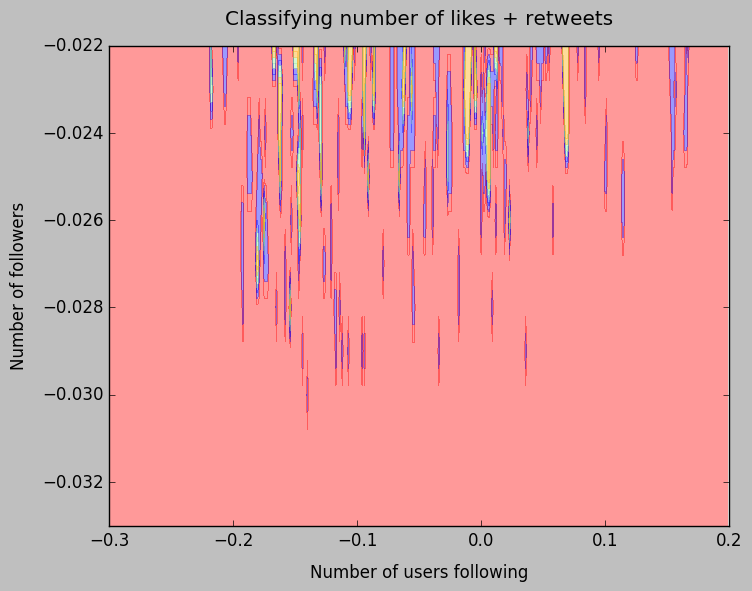

In [294]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_decision_regions(ax,
                      np.vstack((X_train_std, X_test_std))[::10],
                      np.hstack((y_train, y_test))[::10],
                      classifier=knn,
                      l_dict = l_dict,
                      resolution=0.001,
                      limits=[-0.3, 0.2, -0.033, -0.022],
                      plot_samples=False)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.0327, -0.022)

ax.set_xlabel('Number of users following', labelpad=10)
ax.set_ylabel('Number of followers', labelpad=10)
plt.title('Classifying number of likes + retweets', y=1.03)
plt.legend()

plt.savefig('figures/kNN_decision_regions_2_no_samples.png', bbox_inches='tight', dpi=144)

plt.show()

In [297]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_test, y_pred)
cmat

array([[71372,  2212,    65,   598],
       [19875,  2361,   119,   612],
       [ 5343,   850,   166,   690],
       [ 2737,   333,   102,  2808]])

It looks like a ton of low (1-2), moderate (2-6), and high (7+) influence tweets being classified as none (0). This is indicated by the first column.

Let's calculate the accuracy score for each category using the confusion matrix. We can get this by dividing the diagonal entries by the row sums.

In [298]:
cmat.diagonal()/cmat.sum(axis=1)

array([ 0.9612779 ,  0.10279967,  0.02354944,  0.46956522])

This is concerning ... we classify nearly all the 'easy ones' (none) correctly but fail big time with the rest. I'd like to try and classify the low, moderate, and high categories better even if it comes at a cost to the others. Let's see what happens to these as we change k in kNN.

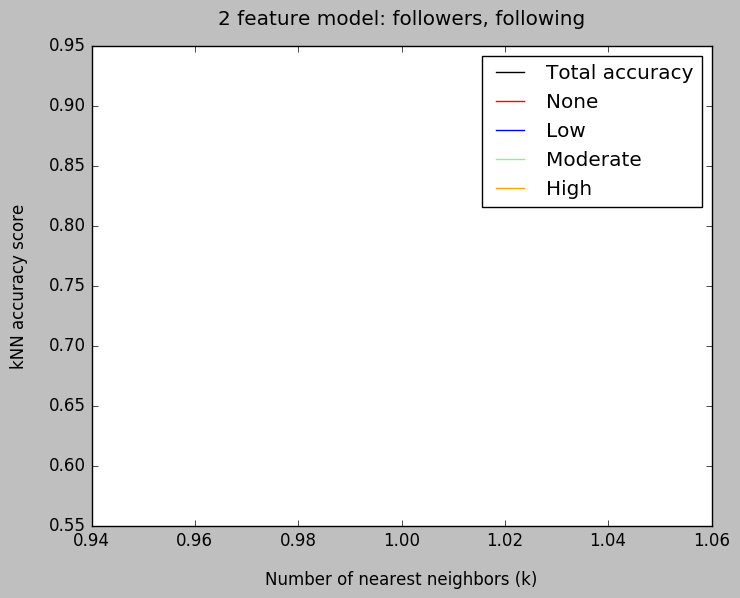

In [311]:
acc, t_acc = [], []
N = 1
for n in range(1,N+1):
    knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)
    cmat = confusion_matrix(y_test, y_pred)
    t_acc.append(accuracy_score(y_test, y_pred))
    acc.append(cmat.diagonal()/cmat.sum(axis=1))

colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    
acc = np.array(acc).T
plt.plot(range(1,N+1), t_acc, label='Total accuracy', color='black')
plt.plot(range(1,N+1), acc[0], label='None', color=colors[0])
plt.plot(range(1,N+1), acc[1], label='Low', color=colors[1])
plt.plot(range(1,N+1), acc[2], label='Moderate', color=colors[2])
plt.plot(range(1,N+1), acc[3], label='High', color=colors[3])
plt.legend()
plt.ylabel('kNN accuracy score', labelpad=15)
plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
plt.title('2 feature model: followers, following', y=1.03)
plt.savefig('figures/kNN_class_accuracy_2_features_followers_following.png', bbox_inches='tight', dpi=144)
plt.show()

#### Try with only one feature (followers) and see if accuracy increases

In [ ]:
# # Get training and testing data from dataframe

# X_train, X_test, y_train, y_test = train_test_split(
#     df_originals[['followers_count']].values,
#     df_originals['influence_category'].values,
#     test_size = 0.3,
#     random_state = 0)

# # Standardize features

# std_sc = StandardScaler()
# std_sc.fit(X_train)
# X_train_std = std_sc.transform(X_train)
# X_test_std = std_sc.transform(X_test)

# knn = KNeighborsClassifier(n_neighbors=20, p=2, metric='minkowski')
# knn.fit(X_train_std, y_train)
# y_pred = knn.predict(X_test_std)
# accuracy_score(y_test, y_pred)

In [ ]:
# acc, t_acc = [], []
# N = 50
# for n in range(1,N+1):
#     knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
#     knn.fit(X_train_std, y_train)
#     y_pred = knn.predict(X_test_std)
#     cmat = confusion_matrix(y_test, y_pred)
#     t_acc.append(accuracy_score(y_test, y_pred))
#     acc.append(cmat.diagonal()/cmat.sum(axis=1))

# colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    
# acc = np.array(acc).T
# plt.plot(range(1,N+1), t_acc, label='Total accuracy', color='black')
# plt.plot(range(1,N+1), acc[0], label='None')
# plt.plot(range(1,N+1), acc[1], label='Low')
# plt.plot(range(1,N+1), acc[2], label='Moderate')
# plt.plot(range(1,N+1), acc[3], label='High')
# plt.ylabel('kNN accuracy score', labelpad=15)
# plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
# plt.legend(loc='best')
# # plt.savefig('figures/kNN_class_accuracy_1_feature_followers.png', bbox_inches='tight', dpi=144)
# plt.show()

With one feature we can plot y vs x, what does this look like?

In [ ]:
# X_train

In [ ]:
# plt.scatter(X_train.T, y_train)
# plt.show()

What if we treat this as a regression problem instead.

In [ ]:
# plt.scatter(df_originals.followers_count.values, df_originals.influence.values, alpha=0.03)
# plt.xlabel('Followers')
# plt.ylabel('Favorites + Retweets')
# plt.xlim(0,100000)
# plt.ylim(0,100)
# plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(df_originals.followers_count.values, df_originals.influence.values, alpha=0.03)
# ax.set_xlabel('Followers')
# ax.set_ylabel('Favorites + Retweets')
# ax.set_xscale('log')
# # ax.set_yscale('log')
# plt.xlim(1,1000000)
# plt.ylim(1,100)
# plt.show()

#### Must use better features for improved classification

From before we have:

x1 = # of followers  
x2 = # following

Lets add a third feature x3 using the created_at column. First use the exact date e.g. May 28th, then use the time of day (independent of the date) and see which one performs better. 

In [299]:
to_timestamp = np.vectorize(lambda x: x.timestamp())
df_originals['timestamp'] = to_timestamp(list(df_originals.created_at))

C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [300]:
X_train, X_test, y_train, y_test = train_test_split(
    df_originals[['followers_count', 'friends_count', 'timestamp']],
    df_originals.influence_category,
    test_size=0.3,
    random_state=0)

In [301]:
std_sc = StandardScaler()
X_train_std = std_sc.fit_transform(X_train)
X_test_std = std_sc.transform(X_test)

In [302]:
knn = KNeighborsClassifier(n_neighbors=50, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print(accuracy_score(y_test, y_pred))
cmat = confusion_matrix(y_test, y_pred)
print(cmat.diagonal()/cmat.sum(axis=1))

0.703953992544
[ 0.97734589  0.12957722  0.02468435  0.31622074]


In [ ]:
acc, t_acc = [], []
N = 50
for n in range(1,N+1):
    knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)
    cmat = confusion_matrix(y_test, y_pred)
    t_acc.append(accuracy_score(y_test, y_pred))
    acc.append(cmat.diagonal()/cmat.sum(axis=1))

colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    
acc = np.array(acc).T
plt.plot(range(1,N+1), t_acc, label='Total accuracy', color='black')
plt.plot(range(1,N+1), acc[0], label='None')
plt.plot(range(1,N+1), acc[1], label='Low')
plt.plot(range(1,N+1), acc[2], label='Moderate')
plt.plot(range(1,N+1), acc[3], label='High')
plt.ylabel('kNN accuracy score', labelpad=15)
plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
plt.title('3 feature model: followers, following, date',y=1.03)

plt.legend()
plt.savefig('figures/kNN_class_accuracy_3_features_followers_following_date.png', bbox_inches='tight', dpi=144)
plt.show()

It helped a little tiny bit. Let's try adding a different time-related feature - the time on a 24 hr clock.

In [303]:
get_times = lambda dtime: dtime.hour + dtime.minute/60.0 + dtime.second/3600.0

df_originals['time_of_day'] = df_originals['created_at'].apply(get_times)

C:\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [304]:
X_train, X_test, y_train, y_test = train_test_split(
    df_originals[['followers_count', 'friends_count', 'time_of_day']],
    df_originals.influence_category,
    test_size=0.3,
    random_state=0)

In [305]:
std_sc = StandardScaler()
X_train_std = std_sc.fit_transform(X_train)
X_test_std = std_sc.transform(X_test)

In [306]:
knn = KNeighborsClassifier(n_neighbors=50, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print(accuracy_score(y_test, y_pred))
cmat = confusion_matrix(y_test, y_pred)
print(cmat.diagonal()/cmat.sum(axis=1))

0.685286140617
[ 0.96503562  0.07401925  0.00936303  0.35635452]


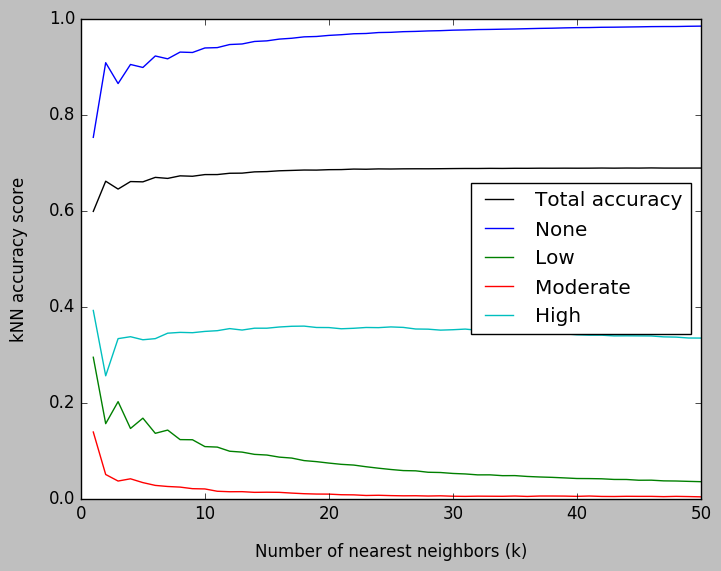

In [307]:
acc, t_acc = [], []
N = 50
for n in range(1,N+1):
    knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)
    cmat = confusion_matrix(y_test, y_pred)
    t_acc.append(accuracy_score(y_test, y_pred))
    acc.append(cmat.diagonal()/cmat.sum(axis=1))

colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    
acc = np.array(acc).T
plt.plot(range(1,N+1), t_acc, label='Total accuracy', color='black')
plt.plot(range(1,N+1), acc[0], label='None')
plt.plot(range(1,N+1), acc[1], label='Low')
plt.plot(range(1,N+1), acc[2], label='Moderate')
plt.plot(range(1,N+1), acc[3], label='High')
plt.ylabel('kNN accuracy score', labelpad=15)
plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
plt.title('3 feature model: followers, following, time of day',y=1.03)
plt.legend()
plt.savefig('figures/kNN_class_accuracy_3_features_followers_following_time-of-day.png', bbox_inches='tight', dpi=144)
plt.show()

What if we cheat a little bit?

In [309]:
X_train, X_test, y_train, y_test = train_test_split(
    df_originals[['followers_count', 'favorite_count']],
    df_originals.influence_category,
    test_size=0.3,
    random_state=0)

std_sc = StandardScaler()
X_train_std = std_sc.fit_transform(X_train)
X_test_std = std_sc.transform(X_test)

In [ ]:
acc, t_acc = [], []
N = 50
for n in range(1,N+1):
    knn = KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski')
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)
    cmat = confusion_matrix(y_test, y_pred)
    t_acc.append(accuracy_score(y_test, y_pred))
    acc.append(cmat.diagonal()/cmat.sum(axis=1))

colors = ('red', 'blue', 'lightgreen', 'orange', 'cyan')
    
acc = np.array(acc).T
plt.plot(range(1,N+1), t_acc, label='Total accuracy', color='black')
plt.plot(range(1,N+1), acc[0], label='None')
plt.plot(range(1,N+1), acc[1], label='Low')
plt.plot(range(1,N+1), acc[2], label='Moderate')
plt.plot(range(1,N+1), acc[3], label='High')
plt.ylabel('kNN accuracy score', labelpad=15)
plt.xlabel('Number of nearest neighbors (k)', labelpad=15)
plt.title('2 feature model: followers, favorites', y=1.03)
plt.legend(loc='best')
plt.savefig('figures/kNN_class_accuracy_2_features_followers_favorites.png', bbox_inches='tight', dpi=144)
plt.show()

What if we cheat a lot??

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_originals[['retweet_count', 'favorite_count']],
    df_originals.influence_category,
    test_size=0.3,
    random_state=0)

std_sc = StandardScaler()
X_train_std = std_sc.fit_transform(X_train)
X_test_std = std_sc.transform(X_test)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=50, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print(accuracy_score(y_test, y_pred))
cmat = confusion_matrix(y_test, y_pred)
print(cmat.diagonal()/cmat.sum(axis=1))